# Portfolio Strategy - Baseline Model

We will implement three portfolio strategies:

1. Shotgun then Prune
2. Prune Losers; Reinvest in Winners
3. Prune Losers; Reinvest in Winners and Newbies

<u>Strategy One - Shotgun then Prune </u>

**First sampling period (3-1-2009 to 12-31-2010)**

Divide cash (e.g. $10 million) evenly into N_1 (e.g. 100) tickers. Tickers are selected though random selection from an unranked prospect list from the Baseline Algorithm.

**Subsequent sampling period (e.g. 3-1-2009 to 12-31-2011)**

Check tickers in the portfolio against the new prospect list. A ticker that is still on the list is considered a "winner". Tickers not on the list are "Losers" and are liquidated to raise cash. 

We repeat this process until the last sampling period (3-1-2009 to 12-31-2018).

**Final Tally** 

Tally up the investment gain by calculating the value of the portfolio (cash + stocks) on 3-31-2019.


<u>Strategy Two - Prune Losers; Reinvest in Winners</u>

**First sampling period (3-1-2009 to 12-31-2010)**

Same as Strategy One.

**Subsequent sampling period (e.g. 3-1-2009 to 12-31-2011)**

Cash raised by selling the Losers is reinvested evenly into the Winners.


<u>Strategy Three - Prune Losers; Reinvest in Winners and Newbies</u>

**First sampling period (3-1-2009 to 12-31-2010)**

Same as Strategy One.

**Subsequent sampling period (e.g. 3-1-2009 to 12-31-2011)**

Cash raised by selling the Losers is invested in new tickers selected from the new prospect list. Investment per ticker is the lesser of Available_Cash/N_new or 1e7/N_2, where N_new is the number of new tickers and N_2 is the number of tickers in the 2nd sampling period (e.g. 90).

If there is still cash left over after investing in these new tickers, it is reinvested evenly into the Winners.

<u>Benchmark against S&P (Jan 2011 - Mar 2019)</u>

The cumulative returns of these strategies are compared against the following S&P 500 returns over the period of Jan 2011 - Mar 2019:

* Total S&P 500 Return -	118.613%
* Annualized S&P 500 Return - 10.051%
* Total S&P 500 Return (Dividends Reinvested)	- 157.353%
* Annualized S&P 500 Return (Dividends Reinvested) - 12.271%


In [321]:
import quandl  # Access to Sharadar Core US Equities Bundle
api_key = '7B87ndLPJbCDzpNHosH3'

import math
import platform

from pylab import rcParams
import numpy as np
from sklearn import linear_model  # package for logistic regression (not using GPU)
import torch
import pandas as pd
from IPython.display import display
import time
import pickle
import random

from utils import *

from datetime import date, datetime, time, timedelta

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())
print("Pytorch version: {}".format(torch.__version__))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python version:  3.6.6
Pytorch version: 1.1.0


## Import Stock Price History

In [176]:
stockprices = pd.read_csv("stock_price_history.cvs")
prices = stockprices.set_index('date')

In [309]:
# Files containing active tickers in the sampling periods
predict_filenames = ['predicts_lin_int_12-31-2010.csv',
              'predicts_lin_int_12-31-2011.csv',
              'predicts_lin_int_12-31-2012.csv',
              'predicts_lin_int_12-31-2013.csv',
              'predicts_lin_int_12-31-2014.csv',
              'predicts_lin_int_12-31-2015.csv',
              'predicts_lin_int_12-31-2016.csv',
              'predicts_lin_int_12-31-2017.csv',
              'predicts_lin_int_12-31-2018.csv'
             ]

# End of sampling period
sampling_end_dates = [
    '2010-12-31',
    '2011-12-30',
    '2012-12-31',
    '2013-12-31',
    '2014-12-31',
    '2015-12-31',
    '2016-12-30',
    '2017-12-29',    
    '2018-12-31'
]

# First January following end of sampling period when portfolio is rebalanced (bought and sold)
rebalance_periods = [
    ('2011-01-03','2011-01-31'),
    ('2012-01-03','2012-01-31'),
    ('2013-01-02','2013-01-31'),
    ('2014-01-02','2014-01-31'),
    ('2015-01-02','2015-01-31'),
    ('2016-01-04','2016-01-31'),
    ('2017-01-03','2017-01-31'),
    ('2018-01-02','2018-01-31'),
    ('2019-01-02','2019-01-31')
]

# End of sampling periods
end_dates = [
    '2010-12-31',
    '2011-12-30',
    '2012-12-31',
    '2013-12-31',
    '2014-12-31',
    '2015-12-31',
    '2016-12-30',
    '2017-12-29',    
    '2018-12-31'
]

# For Strategy One, only the first item is used
portfolio_sizes = [
    100,
    90,
    80,
    70,
    60,
    50,
    40,
    30,
    20
]

START = 1e7 # Start the portfolio with $10M

# the date where the final value of the portfolio is tallied
target_date = '2019-03-29'  

## Import Prospect Lists (Baseline Linear Interpolation)

In [105]:
prospects = {}

for date, predict_filename, buy_period in zip(sampling_end_dates, predict_filenames, buy_periods):
    
    # Get prospect lists for 10 Baggers
    predicts = pd.read_csv("../datasets/sharader/"+predict_filename, index_col=0).set_index('ticker')
    prospects[date] = predicts[predicts['10bagger'] == True]
    
    display(prospects[date])
    
    for ticker in prospects[date].index:
        
        # Determine if ticker has delisted during buy period (First Jan following end of sampling period)
        start, end = buy_period
        delist = prices[ticker].loc[start:end].isnull().values.any()
        
        # Remove delisted ticker from prospect list
        if delist:
            print('Remove delist: {}'.format(ticker))
            prospects[date] = prospects[date].drop(index=ticker)
    

,appreciation,10bagger
ticker,,
A,13.475510,True
AAI,11.506250,True
AAL,17.796318,True
AAME,13.032376,True
AAPL,15.679507,True
...,...,...
ZPLSQ,23.008969,True
ZQKSQ,22.847138,True
ZUMZ,15.342757,True


Remove delist: AEZ
Remove delist: ARTG
Remove delist: BDLN
Remove delist: BELM
Remove delist: BEZ
Remove delist: CLZR
Remove delist: CTV1
Remove delist: DDRX
Remove delist: IRMC
Remove delist: ISLN
Remove delist: KEI
Remove delist: POLGA
Remove delist: PPKZ
Remove delist: ROAC
Remove delist: SSCCQ
Remove delist: TTES


,appreciation,10bagger
ticker,,
AAPL,13.847328,True
ABCO,15.749645,True
ABCP,18.254394,True
ABEV,13.989380,True
ABG,25.681838,True
...,...,...
ZNH,10.227668,True
ZOLL,15.304536,True
ZPCM,42.870039,True


Remove delist: AEZ
Remove delist: BDLN
Remove delist: BELM
Remove delist: BEXP
Remove delist: CALP
Remove delist: CLZR
Remove delist: CRFT
Remove delist: DDRX
Remove delist: HS
Remove delist: HTLLQ
Remove delist: IRMC
Remove delist: ISLN
Remove delist: KEI
Remove delist: MSSR
Remove delist: NAVI1
Remove delist: PNS
Remove delist: PPKZ
Remove delist: RNOW
Remove delist: RURL
Remove delist: RVI1
Remove delist: SFN1
Remove delist: SNIC
Remove delist: SSCCQ
Remove delist: TRXBQ
Remove delist: VRUS
Remove delist: ZARLF


,appreciation,10bagger
ticker,,
AAL,12.741304,True
AAME,11.125020,True
AAPL,14.281838,True
ABCO,15.410088,True
ABCP,11.932293,True
...,...,...
YVR,23.323975,True
ZAGG,12.920747,True
ZARLF,22.222222,True


Remove delist: AEA
Remove delist: AEZ
Remove delist: BDLN
Remove delist: BELM
Remove delist: BEXP
Remove delist: CALP
Remove delist: CBOU
Remove delist: CHRS1
Remove delist: CLSP
Remove delist: CLZR
Remove delist: CPWM
Remove delist: CPX
Remove delist: DDRX
Remove delist: DEIX
Remove delist: DTG
Remove delist: FSII
Remove delist: HDLM
Remove delist: HTLLQ
Remove delist: IGATY
Remove delist: INHX
Remove delist: IRMC
Remove delist: ISLN
Remove delist: KEI
Remove delist: KNXA
Remove delist: LCRY
Remove delist: LMLP1
Remove delist: NAVI1
Remove delist: PPKZ
Remove delist: PXPLY
Remove delist: RURL
Remove delist: RVI1
Remove delist: SFN1
Remove delist: SHF
Remove delist: SNIC
Remove delist: SRZ
Remove delist: SSCCQ
Remove delist: TPCG
Remove delist: TRXBQ
Remove delist: VRUS
Remove delist: ZARLF


,appreciation,10bagger
ticker,,
AAL,20.234366,True
AAMC,367.159269,True
AAME,12.305200,True
AAPL,12.219286,True
ABCO,17.306016,True
...,...,...
ZARLF,22.222222,True
ZIOP,11.662754,True
ZLC,28.279770,True


Remove delist: AEA
Remove delist: AEZ
Remove delist: BDLN
Remove delist: BELM
Remove delist: BEXP
Remove delist: BKI1
Remove delist: BLC
Remove delist: BZ
Remove delist: CALP
Remove delist: CGX
Remove delist: CHRS1
Remove delist: CLZR
Remove delist: CPWM
Remove delist: CPX
Remove delist: DDRX
Remove delist: DEIX
Remove delist: DTG
Remove delist: EDAC
Remove delist: FIRE
Remove delist: FSII
Remove delist: HMA
Remove delist: HTLLQ
Remove delist: INHX
Remove delist: INOC
Remove delist: IRMC
Remove delist: ISLN
Remove delist: KEI
Remove delist: KNXA
Remove delist: LCC
Remove delist: LCRY
Remove delist: MAPP
Remove delist: MCBI1
Remove delist: NAVI1
Remove delist: NFP
Remove delist: PBTH
Remove delist: PPKZ
Remove delist: PTYA
Remove delist: PWER
Remove delist: PXPLY
Remove delist: RURL
Remove delist: RVI1
Remove delist: SFN1
Remove delist: SHF
Remove delist: SHS
Remove delist: SNIC
Remove delist: SNTS
Remove delist: SPRD
Remove delist: SRZ
Remove delist: SSCCQ
Remove delist: TPCG
Remove de

,appreciation,10bagger
ticker,,
AAL,36.794788,True
AAMC,61.470667,True
AAME,10.205145,True
AAPL,14.455728,True
AAXN,11.948262,True
...,...,...
YY,14.600265,True
ZARLF,22.222222,True
ZIOP,11.612418,True


Remove delist: AEA
Remove delist: AEZ
Remove delist: ARTC
Remove delist: ATHYQ
Remove delist: ATX
Remove delist: AVNR
Remove delist: BDLN
Remove delist: BELM
Remove delist: BEXP
Remove delist: BKI1
Remove delist: BLC
Remove delist: BWEBF
Remove delist: BZ
Remove delist: CALP
Remove delist: CBST
Remove delist: CCIX
Remove delist: CHRS1
Remove delist: CLZR
Remove delist: CPWM
Remove delist: CPX
Remove delist: CSE
Remove delist: DDRX
Remove delist: DEIX
Remove delist: DTG
Remove delist: EDAC
Remove delist: EVOQ
Remove delist: FIRE
Remove delist: FSII
Remove delist: GENTY
Remove delist: GRT
Remove delist: HTLLQ
Remove delist: INHX
Remove delist: INOC
Remove delist: IRMC
Remove delist: ISLN
Remove delist: KEI
Remove delist: KFN
Remove delist: KNXA
Remove delist: KOG
Remove delist: LCC
Remove delist: LCRY
Remove delist: MAPP
Remove delist: MASC
Remove delist: MEAS
Remove delist: MGAM
Remove delist: NAVI1
Remove delist: NFP
Remove delist: PBTH
Remove delist: PPKZ
Remove delist: PTYA
Remove de

,appreciation,10bagger
ticker,,
AAL,24.820642,True
AAME,11.081949,True
AAPL,11.885981,True
ABCB,10.355572,True
ABCP,16.918258,True
...,...,...
YY,10.250117,True
ZAGG,11.660241,True
ZARLF,22.222222,True


Remove delist: AEA
Remove delist: AEZ
Remove delist: ARTC
Remove delist: ATLS1
Remove delist: ATX
Remove delist: AVNR
Remove delist: BDLN
Remove delist: BEE
Remove delist: BELM
Remove delist: BEXP
Remove delist: BKI1
Remove delist: BLC
Remove delist: BWEBF
Remove delist: BZ
Remove delist: CALP
Remove delist: CCIX
Remove delist: CHRS1
Remove delist: CLZR
Remove delist: CMTX
Remove delist: CPWM
Remove delist: CPX
Remove delist: CSE
Remove delist: CTRX
Remove delist: CYT
Remove delist: DDRX
Remove delist: DEIX
Remove delist: DTG
Remove delist: DYAX
Remove delist: EDAC
Remove delist: EVOQ
Remove delist: FIRE
Remove delist: FSII
Remove delist: GENTY
Remove delist: GEVA
Remove delist: GRT
Remove delist: HILL
Remove delist: HTLLQ
Remove delist: IGTE
Remove delist: INHX
Remove delist: INOC
Remove delist: IRMC
Remove delist: ISLN
Remove delist: ISSI
Remove delist: JRN
Remove delist: KEI
Remove delist: KFN
Remove delist: KNXA
Remove delist: KOG
Remove delist: LBMH
Remove delist: LCC
Remove delis

,appreciation,10bagger
ticker,,
AAL,24.042074,True
AAPL,11.578545,True
ABCB,11.833011,True
ABG,28.908446,True
ABMD,23.843761,True
...,...,...
XPO,16.051065,True
YMI,12.250000,True
YUANF,13.502897,True


Remove delist: ACAS
Remove delist: AEA
Remove delist: AEPI
Remove delist: AEZ
Remove delist: AFOP
Remove delist: AICIQ
Remove delist: ANAC
Remove delist: ARMH
Remove delist: ARTC
Remove delist: ATLS1
Remove delist: ATX
Remove delist: AVNR
Remove delist: BDLN
Remove delist: BEE
Remove delist: BELM
Remove delist: BEXP
Remove delist: BKI1
Remove delist: BLC
Remove delist: BWEBF
Remove delist: BZ
Remove delist: CALP
Remove delist: CCIX
Remove delist: CHRS1
Remove delist: CKEC
Remove delist: CLZR
Remove delist: CMTX
Remove delist: CPWM
Remove delist: CPX
Remove delist: CSE
Remove delist: CTRX
Remove delist: CYT
Remove delist: DDRX
Remove delist: DEIX
Remove delist: DTG
Remove delist: DYAX
Remove delist: EDAC
Remove delist: EVOQ
Remove delist: FIRE
Remove delist: FNAM
Remove delist: FSII
Remove delist: GENTY
Remove delist: GEVA
Remove delist: GMCR
Remove delist: GMKYY
Remove delist: GRT
Remove delist: HILL
Remove delist: HPY
Remove delist: HTLLQ
Remove delist: IGTE
Remove delist: IMOS1
Remov

,appreciation,10bagger
ticker,,
AAL,23.908947,True
AAPL,15.238195,True
ABCB,11.744281,True
ABG,26.722942,True
ABMD,35.461454,True
...,...,...
YUANF,17.677696,True
YY,12.202141,True
ZAGG,15.696804,True


Remove delist: ACAS
Remove delist: AEA
Remove delist: AEZ
Remove delist: AFOP
Remove delist: AICIQ
Remove delist: ANAC
Remove delist: ARIA
Remove delist: ARIS
Remove delist: ARMH
Remove delist: ARTC
Remove delist: ATLS1
Remove delist: ATX
Remove delist: AVNR
Remove delist: BDLN
Remove delist: BEE
Remove delist: BELM
Remove delist: BEXP
Remove delist: BKI1
Remove delist: BLC
Remove delist: BWEBF
Remove delist: BZ
Remove delist: CALP
Remove delist: CCIX
Remove delist: CHRS1
Remove delist: CKEC
Remove delist: CLZR
Remove delist: CMTX
Remove delist: CPWM
Remove delist: CPX
Remove delist: CSE
Remove delist: CTRX
Remove delist: CYNO
Remove delist: CYT
Remove delist: DDRX
Remove delist: DEIX
Remove delist: DFT
Remove delist: DTG
Remove delist: DTRX
Remove delist: DYAX
Remove delist: EDAC
Remove delist: ERS
Remove delist: EVOQ
Remove delist: FIRE
Remove delist: FNAM
Remove delist: FSII
Remove delist: GENTY
Remove delist: GEVA
Remove delist: GMCR
Remove delist: GMKYY
Remove delist: GRT
Remove d

,appreciation,10bagger
ticker,,
AAL,13.300752,True
AAPL,12.845540,True
AAXN,12.397788,True
ABG,25.096510,True
ABMD,55.413601,True
...,...,...
XPO,17.171871,True
YMI,12.250000,True
YUANF,11.323845,True


Remove delist: ACAS
Remove delist: AEA
Remove delist: AET
Remove delist: AEZ
Remove delist: AFOP
Remove delist: AICIQ
Remove delist: ANAC
Remove delist: ANDV
Remove delist: ARIA
Remove delist: ARII
Remove delist: ARIS
Remove delist: ARMH
Remove delist: ARTC
Remove delist: ATLS1
Remove delist: ATX
Remove delist: AVNR
Remove delist: AVXS
Remove delist: BDLN
Remove delist: BEE
Remove delist: BELM
Remove delist: BEXP
Remove delist: BKI1
Remove delist: BLC
Remove delist: BWEBF
Remove delist: BZ
Remove delist: CAA
Remove delist: CALD
Remove delist: CALP
Remove delist: CCIX
Remove delist: CHRS1
Remove delist: CKEC
Remove delist: CLZR
Remove delist: CMTX
Remove delist: CPWM
Remove delist: CPX
Remove delist: CSE
Remove delist: CTRX
Remove delist: CYNO
Remove delist: CYT
Remove delist: DDRX
Remove delist: DEIX
Remove delist: DFT
Remove delist: DTG
Remove delist: DTRX
Remove delist: DWCH
Remove delist: DYAX
Remove delist: EDAC
Remove delist: ELXS
Remove delist: ERS
Remove delist: EVOQ
Remove deli

In [161]:
prospects['2018-12-31']

,appreciation,10bagger
ticker,,
AAL,13.300752,True
AAPL,12.845540,True
AAXN,12.397788,True
ABG,25.096510,True
ABMD,55.413601,True
...,...,...
WLK,11.500578,True
WNS,11.723294,True
WYND,11.455639,True


## Useful Functions

In [349]:
def random_select(prospects, num_tickers, invalids=[]):
    # Randomly pick a number of valid tickers from prospect_list
   
    if (len(prospects)-len(invalids)) < num_tickers:
        print('Not enough tickers in prospect list!')
        selections = None
    else:
        selections = []
        num = 0
        while num < num_tickers:
            ticker = random.sample(prospects, 1)  # pick a ticker
            if not (ticker[0] in invalids+selections):
                # print(ticker[0])
                # print(invalids+selections)
                selections.append(ticker[0])  # add to select if ticker is valid and has not been picked already
                num += 1
    return selections

def average_price(ticker, start, end):
    # Calculate average price of a ticker in period between start and end
    # The function assumes there is a global dataset "prices"
    
    # get the ticker's prices in the period (drop the NaNs)
    prices_history = list(prices[ticker].loc[start:end].dropna())   
    
    return sum(prices_history)/len(prices_history)

def liquidate(tickers, holdings, start, end, debug=False):
    # Liquidate holding in period between start and end
    # The function assumes there is a global dataset "prices"

    total = 0
    price_list = []
    
    for ticker in tickers:
        if math.isnan(prices[ticker].loc[start]):
            # If stock has been delisted before rebalance period, get price at date of delist
            delist_price = prices[ticker].loc[prices[ticker].last_valid_index()] 
            price_list.append(delist_price)
        else:
            price_list.append(average_price(ticker, start, end)) 
   
    for ticker, num_shares, price in zip(tickers, holdings, price_list):
        if debug:
            print("{}: Liquidate {:.1f} sh at ${:.2f}".format(ticker, num_shares, price))
        total += num_shares * price
        
    return total

def invest_evenly(tickers, holdings, cash, start, end, debug=False):
    # Invest the cash evenly between the tickers over the rebalancing period (defined by start and end). 
    # Return updated holding as a list. 
    
    new_holdings = []
    
    for ticker, holding in zip(tickers, holdings):

        buy_price = average_price(ticker, start, end) # find average price during rebalance period
        shares_added = cash/buy_price   # calculate and save number of shares bought
        new_holdings.append(holding + shares_added)

        if debug:
            print("{}: Buy {:.1f} sh at ${:.2f}".format(ticker, shares_added, buy_price))
    
    return new_holdings
    

def portfolio_value(tickers, holdings, date, debug=False):
    # Value of portfolio on a specific date
    # The function assumes there is a global dataset "prices"
    
    # print('Calculate value of stock holdings on {}:'.format(date))

    total = 0
    price_list = []
    
    for ticker in tickers:
        if math.isnan(prices[ticker].loc[date]):
            # If stock has been delisted before rebalance period, get price at date of delist
            delist_price = prices[ticker].loc[prices[ticker].last_valid_index()] 
            price_list.append(delist_price)
        else:
            price_list.append(prices[ticker].loc[date]) 
   
    for ticker, num_shares, price in zip(tickers, holdings, price_list):
        if debug:
            print("{}: {:.1f} sh at ${:.2f}".format(ticker, num_shares, price))
        total += num_shares * price
        
    return total

def identify_winners(tickers, prospects):
    # If a ticker in the portfolio is in the prospect list, identify it as a winner.
    
    winners = []
    losers = []
    
    for ticker in tickers:
        if ticker in prospects:
            winners.append(ticker)
        else:
            losers.append(ticker)
    
    return winners, losers

def prune_losers(portfolio, tickers, debug=False):
    # Take the input portfolio and prune away the losers
    loser_tickers = []
    loser_holdings = []
    new_portfolio = {}
    new_portfolio['tickers']=[]
    new_portfolio['num_shares']=[]
    
    for ticker, num_shares in zip(portfolio['tickers'], portfolio['num_shares']):
        if ticker in tickers:
            if debug:
                print('Loser: {}sh of {}'.format(num_shares, ticker))
            # Sell the losers
            loser_tickers.append(ticker)
            loser_holdings.append(num_shares) 
        else:
            # keep the winners
            if debug:
                print('Winner: {}sh of {}'.format(num_shares, ticker))
            new_portfolio['tickers'].append(ticker)
            new_portfolio['num_shares'].append(num_shares) 
            
    return new_portfolio, loser_tickers, loser_holdings

# Implement Strategy One (Shotgun then Prune)

In [297]:
num_iterations = 2000
returns = []
debug = False

for i in range(num_iterations):
    
    # Execute Strategy One 

    portfolio = {}
    last = None   # to save the last portfolio
    start_cash = START  # Start with $10M

    for date, num_tickers, rebalance_period in zip(end_dates,portfolio_sizes, rebalance_periods):
        
        if debug:
            print('Portfolio: {}'.format(date))
        start, end = rebalance_period

        if last is None:  # Create the portfolio for the first time

            if debug:
                print("Shotgun!")

            portfolio[date] = {}
            # Randomly select a set number of tickers from the prospect list (SHOTGUN)
            portfolio[date]['tickers'] = random_select(list(prospects[date].index), num_tickers)  
            portfolio[date]['num_shares'] = [0 for x in portfolio[date]['tickers']]

            # Invest cash evenly between the tickers
            invest = start_cash/num_tickers  
            portfolio[date]['num_shares'] = invest_evenly(portfolio[date]['tickers'], \
                                                         portfolio[date]['num_shares'], \
                                                         invest, start, end, debug=debug)

            last = portfolio[date].copy()   # Save a copy of the portfolio for later iterations
            cash = 0  # No more cash left

        else:   # Prune portfolio - Keep only the Winners

            if debug:
                print("Prune!")

            portfolio[date] = {}
            loser_tickers = []
            loser_holdings = []

            # If a ticker in the portfolio is on the new prospect list, keep it as a Winner.
            # If a ticker is not on the new prospect list, sell its position for cash
            winners, losers = identify_winners(last['tickers'], list(prospects[date].index))
            portfolio[date],loser_tickers,loser_holdings = prune_losers(last, losers, debug=debug)  

            # Liquidate Losers for cash during rebalance period
            liquidation = liquidate(loser_tickers, loser_holdings, start, end, debug=debug)
            cash += liquidation

            if debug:
                print('Winners: {}'.format(winners))
                print('Losers: {}'.format(losers))
                print('Cash harvested from Losers: ${:.2f}'.format(liquidation))   
                print('\n')

            last = portfolio[date].copy()   # Save portfolio for later iterations

    # Calculate value of the stock holdings on target date
    equity = portfolio_value(last['tickers'], last['num_shares'], target_date)
    total = equity + cash
    
    # Calculate and save portfolio return
    portfolio_return = (total/start_cash-1)*100
    returns.append(portfolio_return)

    print('Equity is valued at: ${:.2f}'.format(equity))
    print('Cash Position: ${:.2f}'.format(cash))
    print('Portfolio Total: ${:.2f}'.format(total))
    print('Portfolio appreciates by {:.1f} %'.format(portfolio_return))
    print('\n')
    
        
    

Equity is valued at: $2367936.06
Cash Position: $8045278.84
Portfolio Total: $10413214.91
Portfolio appreciates by 4.1 %


Equity is valued at: $455757.60
Cash Position: $9470281.77
Portfolio Total: $9926039.37
Portfolio appreciates by -0.7 %


Equity is valued at: $2596917.66
Cash Position: $8614224.50
Portfolio Total: $11211142.16
Portfolio appreciates by 12.1 %


Equity is valued at: $3057275.48
Cash Position: $8752897.78
Portfolio Total: $11810173.26
Portfolio appreciates by 18.1 %


Equity is valued at: $1831029.03
Cash Position: $8774246.94
Portfolio Total: $10605275.98
Portfolio appreciates by 6.1 %


Equity is valued at: $1774843.97
Cash Position: $7665821.32
Portfolio Total: $9440665.29
Portfolio appreciates by -5.6 %


Equity is valued at: $2460354.51
Cash Position: $8996212.28
Portfolio Total: $11456566.79
Portfolio appreciates by 14.6 %


Equity is valued at: $7505120.90
Cash Position: $8218019.01
Portfolio Total: $15723139.91
Portfolio appreciates by 57.2 %


Equity is val

Equity is valued at: $4629962.52
Cash Position: $9255180.97
Portfolio Total: $13885143.49
Portfolio appreciates by 38.9 %


Equity is valued at: $4398196.96
Cash Position: $7552989.26
Portfolio Total: $11951186.22
Portfolio appreciates by 19.5 %


Equity is valued at: $9277610.03
Cash Position: $8086619.29
Portfolio Total: $17364229.32
Portfolio appreciates by 73.6 %


Equity is valued at: $3909178.60
Cash Position: $8585533.15
Portfolio Total: $12494711.75
Portfolio appreciates by 24.9 %


Equity is valued at: $2057628.73
Cash Position: $9560173.20
Portfolio Total: $11617801.93
Portfolio appreciates by 16.2 %


Equity is valued at: $5601545.52
Cash Position: $8347208.49
Portfolio Total: $13948754.01
Portfolio appreciates by 39.5 %


Equity is valued at: $1737483.52
Cash Position: $8310670.57
Portfolio Total: $10048154.09
Portfolio appreciates by 0.5 %


Equity is valued at: $2631382.96
Cash Position: $12963388.50
Portfolio Total: $15594771.46
Portfolio appreciates by 55.9 %


Equity i

Equity is valued at: $1823866.30
Cash Position: $8880919.37
Portfolio Total: $10704785.67
Portfolio appreciates by 7.0 %


Equity is valued at: $3282322.97
Cash Position: $8083430.19
Portfolio Total: $11365753.15
Portfolio appreciates by 13.7 %


Equity is valued at: $1536376.94
Cash Position: $8854521.06
Portfolio Total: $10390898.00
Portfolio appreciates by 3.9 %


Equity is valued at: $4220951.80
Cash Position: $7564271.28
Portfolio Total: $11785223.08
Portfolio appreciates by 17.9 %


Equity is valued at: $9161497.54
Cash Position: $7629068.37
Portfolio Total: $16790565.91
Portfolio appreciates by 67.9 %


Equity is valued at: $3295256.39
Cash Position: $8249162.21
Portfolio Total: $11544418.60
Portfolio appreciates by 15.4 %


Equity is valued at: $4041293.92
Cash Position: $7928802.71
Portfolio Total: $11970096.63
Portfolio appreciates by 19.7 %


Equity is valued at: $2697679.03
Cash Position: $8509375.93
Portfolio Total: $11207054.96
Portfolio appreciates by 12.1 %


Equity is 

Equity is valued at: $1307775.95
Cash Position: $8498003.40
Portfolio Total: $9805779.35
Portfolio appreciates by -1.9 %


Equity is valued at: $2824473.13
Cash Position: $8205620.07
Portfolio Total: $11030093.19
Portfolio appreciates by 10.3 %


Equity is valued at: $4042875.03
Cash Position: $8127474.79
Portfolio Total: $12170349.81
Portfolio appreciates by 21.7 %


Equity is valued at: $10622484.79
Cash Position: $8476601.73
Portfolio Total: $19099086.52
Portfolio appreciates by 91.0 %


Equity is valued at: $653722.55
Cash Position: $9203640.25
Portfolio Total: $9857362.80
Portfolio appreciates by -1.4 %


Equity is valued at: $3590843.26
Cash Position: $8323006.10
Portfolio Total: $11913849.36
Portfolio appreciates by 19.1 %


Equity is valued at: $2274319.06
Cash Position: $8045787.88
Portfolio Total: $10320106.93
Portfolio appreciates by 3.2 %


Equity is valued at: $5570188.79
Cash Position: $8213144.85
Portfolio Total: $13783333.64
Portfolio appreciates by 37.8 %


Equity is v

Equity is valued at: $2479435.02
Cash Position: $9916990.30
Portfolio Total: $12396425.32
Portfolio appreciates by 24.0 %


Equity is valued at: $5275674.36
Cash Position: $7597855.40
Portfolio Total: $12873529.76
Portfolio appreciates by 28.7 %


Equity is valued at: $4902136.72
Cash Position: $8647141.46
Portfolio Total: $13549278.17
Portfolio appreciates by 35.5 %


Equity is valued at: $3777156.86
Cash Position: $8775990.49
Portfolio Total: $12553147.35
Portfolio appreciates by 25.5 %


Equity is valued at: $2100450.43
Cash Position: $7758691.69
Portfolio Total: $9859142.12
Portfolio appreciates by -1.4 %


Equity is valued at: $2400289.38
Cash Position: $8098591.58
Portfolio Total: $10498880.96
Portfolio appreciates by 5.0 %


Equity is valued at: $3866168.21
Cash Position: $8224319.25
Portfolio Total: $12090487.46
Portfolio appreciates by 20.9 %


Equity is valued at: $3441031.49
Cash Position: $8218423.11
Portfolio Total: $11659454.60
Portfolio appreciates by 16.6 %


Equity is 

Equity is valued at: $2864014.29
Cash Position: $7671625.95
Portfolio Total: $10535640.24
Portfolio appreciates by 5.4 %


Equity is valued at: $4311671.98
Cash Position: $10403276.22
Portfolio Total: $14714948.20
Portfolio appreciates by 47.1 %


Equity is valued at: $4712660.91
Cash Position: $7803667.60
Portfolio Total: $12516328.51
Portfolio appreciates by 25.2 %


Equity is valued at: $3178419.68
Cash Position: $8756337.15
Portfolio Total: $11934756.83
Portfolio appreciates by 19.3 %


Equity is valued at: $10375338.33
Cash Position: $8157524.82
Portfolio Total: $18532863.14
Portfolio appreciates by 85.3 %


Equity is valued at: $3128977.36
Cash Position: $8294837.35
Portfolio Total: $11423814.70
Portfolio appreciates by 14.2 %


Equity is valued at: $9039816.18
Cash Position: $7856213.35
Portfolio Total: $16896029.53
Portfolio appreciates by 69.0 %


Equity is valued at: $4845249.43
Cash Position: $8205881.69
Portfolio Total: $13051131.12
Portfolio appreciates by 30.5 %


Equity 

Equity is valued at: $3613071.51
Cash Position: $7968489.28
Portfolio Total: $11581560.80
Portfolio appreciates by 15.8 %


Equity is valued at: $1180806.61
Cash Position: $8866864.42
Portfolio Total: $10047671.03
Portfolio appreciates by 0.5 %


Equity is valued at: $4789502.36
Cash Position: $7936690.89
Portfolio Total: $12726193.26
Portfolio appreciates by 27.3 %


Equity is valued at: $2628826.14
Cash Position: $8235305.88
Portfolio Total: $10864132.02
Portfolio appreciates by 8.6 %


Equity is valued at: $2372548.82
Cash Position: $8472483.43
Portfolio Total: $10845032.25
Portfolio appreciates by 8.5 %


Equity is valued at: $1616525.12
Cash Position: $9174211.59
Portfolio Total: $10790736.71
Portfolio appreciates by 7.9 %


Equity is valued at: $7617966.01
Cash Position: $8092882.55
Portfolio Total: $15710848.55
Portfolio appreciates by 57.1 %


Equity is valued at: $4966505.53
Cash Position: $8144312.54
Portfolio Total: $13110818.07
Portfolio appreciates by 31.1 %


Equity is va

Equity is valued at: $3010605.43
Cash Position: $9036858.02
Portfolio Total: $12047463.45
Portfolio appreciates by 20.5 %


Equity is valued at: $3355461.61
Cash Position: $12308474.29
Portfolio Total: $15663935.89
Portfolio appreciates by 56.6 %


Equity is valued at: $925070.77
Cash Position: $10998657.65
Portfolio Total: $11923728.43
Portfolio appreciates by 19.2 %


Equity is valued at: $4324201.88
Cash Position: $7446165.68
Portfolio Total: $11770367.56
Portfolio appreciates by 17.7 %


Equity is valued at: $2666207.37
Cash Position: $8580563.99
Portfolio Total: $11246771.37
Portfolio appreciates by 12.5 %


Equity is valued at: $3620445.49
Cash Position: $8406089.31
Portfolio Total: $12026534.79
Portfolio appreciates by 20.3 %


Equity is valued at: $2276289.57
Cash Position: $12453925.41
Portfolio Total: $14730214.98
Portfolio appreciates by 47.3 %


Equity is valued at: $3825409.74
Cash Position: $11984735.79
Portfolio Total: $15810145.53
Portfolio appreciates by 58.1 %


Equit

Equity is valued at: $1119802.75
Cash Position: $8409833.53
Portfolio Total: $9529636.27
Portfolio appreciates by -4.7 %


Equity is valued at: $9147492.91
Cash Position: $8685123.32
Portfolio Total: $17832616.24
Portfolio appreciates by 78.3 %


Equity is valued at: $4522286.29
Cash Position: $7846880.36
Portfolio Total: $12369166.65
Portfolio appreciates by 23.7 %


Equity is valued at: $2399238.38
Cash Position: $11846861.75
Portfolio Total: $14246100.13
Portfolio appreciates by 42.5 %


Equity is valued at: $1480812.48
Cash Position: $9942446.90
Portfolio Total: $11423259.38
Portfolio appreciates by 14.2 %


Equity is valued at: $2498289.80
Cash Position: $8488209.42
Portfolio Total: $10986499.22
Portfolio appreciates by 9.9 %


Equity is valued at: $10063701.37
Cash Position: $8340835.94
Portfolio Total: $18404537.31
Portfolio appreciates by 84.0 %


Equity is valued at: $2205237.05
Cash Position: $9153172.00
Portfolio Total: $11358409.05
Portfolio appreciates by 13.6 %


Equity i

Equity is valued at: $3253265.13
Cash Position: $7194929.76
Portfolio Total: $10448194.89
Portfolio appreciates by 4.5 %


Equity is valued at: $2586529.69
Cash Position: $9187544.23
Portfolio Total: $11774073.93
Portfolio appreciates by 17.7 %


Equity is valued at: $3066185.78
Cash Position: $8920317.71
Portfolio Total: $11986503.49
Portfolio appreciates by 19.9 %


Equity is valued at: $2199980.46
Cash Position: $7511723.80
Portfolio Total: $9711704.26
Portfolio appreciates by -2.9 %


Equity is valued at: $7620830.31
Cash Position: $7568524.78
Portfolio Total: $15189355.09
Portfolio appreciates by 51.9 %


Equity is valued at: $10899546.39
Cash Position: $8192341.28
Portfolio Total: $19091887.67
Portfolio appreciates by 90.9 %


Equity is valued at: $4771413.05
Cash Position: $7719579.06
Portfolio Total: $12490992.11
Portfolio appreciates by 24.9 %


Equity is valued at: $2334288.10
Cash Position: $8161619.06
Portfolio Total: $10495907.15
Portfolio appreciates by 5.0 %


Equity is 

Equity is valued at: $2171662.07
Cash Position: $9825051.37
Portfolio Total: $11996713.44
Portfolio appreciates by 20.0 %


Equity is valued at: $3266906.58
Cash Position: $8211523.99
Portfolio Total: $11478430.57
Portfolio appreciates by 14.8 %


Equity is valued at: $7759799.21
Cash Position: $7501096.26
Portfolio Total: $15260895.46
Portfolio appreciates by 52.6 %


Equity is valued at: $1636344.29
Cash Position: $8698510.49
Portfolio Total: $10334854.78
Portfolio appreciates by 3.3 %


Equity is valued at: $2729493.68
Cash Position: $8677683.90
Portfolio Total: $11407177.58
Portfolio appreciates by 14.1 %


Equity is valued at: $3562586.26
Cash Position: $11300867.20
Portfolio Total: $14863453.46
Portfolio appreciates by 48.6 %


Equity is valued at: $3852986.34
Cash Position: $8381734.98
Portfolio Total: $12234721.32
Portfolio appreciates by 22.3 %


Equity is valued at: $2673178.35
Cash Position: $8314508.49
Portfolio Total: $10987686.84
Portfolio appreciates by 9.9 %


Equity is

Equity is valued at: $3887339.38
Cash Position: $6700127.68
Portfolio Total: $10587467.07
Portfolio appreciates by 5.9 %


Equity is valued at: $2032877.05
Cash Position: $6971314.55
Portfolio Total: $9004191.60
Portfolio appreciates by -10.0 %


Equity is valued at: $3224570.14
Cash Position: $7185869.28
Portfolio Total: $10410439.42
Portfolio appreciates by 4.1 %


Equity is valued at: $2322504.11
Cash Position: $12947872.48
Portfolio Total: $15270376.60
Portfolio appreciates by 52.7 %


Equity is valued at: $1448127.98
Cash Position: $9781825.73
Portfolio Total: $11229953.71
Portfolio appreciates by 12.3 %


Equity is valued at: $3175916.94
Cash Position: $9746991.66
Portfolio Total: $12922908.59
Portfolio appreciates by 29.2 %


Equity is valued at: $2603794.62
Cash Position: $7112195.98
Portfolio Total: $9715990.59
Portfolio appreciates by -2.8 %


Equity is valued at: $3191431.68
Cash Position: $7832289.49
Portfolio Total: $11023721.16
Portfolio appreciates by 10.2 %


Equity is 

Equity is valued at: $3117504.87
Cash Position: $8888619.16
Portfolio Total: $12006124.03
Portfolio appreciates by 20.1 %


Equity is valued at: $2666414.68
Cash Position: $8037904.83
Portfolio Total: $10704319.51
Portfolio appreciates by 7.0 %


Equity is valued at: $3919889.36
Cash Position: $7748884.79
Portfolio Total: $11668774.15
Portfolio appreciates by 16.7 %


Equity is valued at: $3129768.05
Cash Position: $8169749.63
Portfolio Total: $11299517.69
Portfolio appreciates by 13.0 %


Equity is valued at: $435451.44
Cash Position: $9802841.58
Portfolio Total: $10238293.03
Portfolio appreciates by 2.4 %


Equity is valued at: $3258310.41
Cash Position: $9051280.02
Portfolio Total: $12309590.43
Portfolio appreciates by 23.1 %


Equity is valued at: $2616288.54
Cash Position: $8363498.42
Portfolio Total: $10979786.96
Portfolio appreciates by 9.8 %


Equity is valued at: $5193483.06
Cash Position: $7307545.83
Portfolio Total: $12501028.89
Portfolio appreciates by 25.0 %


Equity is va

Equity is valued at: $3474037.59
Cash Position: $7329827.65
Portfolio Total: $10803865.24
Portfolio appreciates by 8.0 %


Equity is valued at: $2368388.48
Cash Position: $7833199.82
Portfolio Total: $10201588.31
Portfolio appreciates by 2.0 %


Equity is valued at: $1967949.76
Cash Position: $8185925.78
Portfolio Total: $10153875.54
Portfolio appreciates by 1.5 %


Equity is valued at: $1050782.15
Cash Position: $9010567.70
Portfolio Total: $10061349.86
Portfolio appreciates by 0.6 %


Equity is valued at: $2737699.98
Cash Position: $10649521.09
Portfolio Total: $13387221.08
Portfolio appreciates by 33.9 %


Equity is valued at: $3989749.17
Cash Position: $8237181.86
Portfolio Total: $12226931.03
Portfolio appreciates by 22.3 %


Equity is valued at: $2583126.30
Cash Position: $8779258.98
Portfolio Total: $11362385.29
Portfolio appreciates by 13.6 %


Equity is valued at: $5576062.61
Cash Position: $10779772.79
Portfolio Total: $16355835.40
Portfolio appreciates by 63.6 %


Equity is 

Equity is valued at: $4376130.59
Cash Position: $8661772.09
Portfolio Total: $13037902.67
Portfolio appreciates by 30.4 %


Equity is valued at: $1871319.60
Cash Position: $8664808.13
Portfolio Total: $10536127.73
Portfolio appreciates by 5.4 %


Equity is valued at: $2465883.13
Cash Position: $8045062.61
Portfolio Total: $10510945.74
Portfolio appreciates by 5.1 %


Equity is valued at: $8648957.98
Cash Position: $7559193.32
Portfolio Total: $16208151.30
Portfolio appreciates by 62.1 %


Equity is valued at: $4873852.97
Cash Position: $8330047.62
Portfolio Total: $13203900.59
Portfolio appreciates by 32.0 %


Equity is valued at: $2239678.15
Cash Position: $9338531.59
Portfolio Total: $11578209.74
Portfolio appreciates by 15.8 %


Equity is valued at: $2325511.23
Cash Position: $8350133.21
Portfolio Total: $10675644.44
Portfolio appreciates by 6.8 %


Equity is valued at: $3229162.71
Cash Position: $9097895.63
Portfolio Total: $12327058.34
Portfolio appreciates by 23.3 %


Equity is v

Equity is valued at: $3211896.34
Cash Position: $8911018.71
Portfolio Total: $12122915.04
Portfolio appreciates by 21.2 %


Equity is valued at: $3795716.39
Cash Position: $7033726.62
Portfolio Total: $10829443.01
Portfolio appreciates by 8.3 %


Equity is valued at: $2840787.73
Cash Position: $10557718.64
Portfolio Total: $13398506.37
Portfolio appreciates by 34.0 %


Equity is valued at: $3822123.67
Cash Position: $9559190.64
Portfolio Total: $13381314.31
Portfolio appreciates by 33.8 %


Equity is valued at: $2930899.75
Cash Position: $8464757.59
Portfolio Total: $11395657.34
Portfolio appreciates by 14.0 %


Equity is valued at: $7575197.28
Cash Position: $12190763.90
Portfolio Total: $19765961.18
Portfolio appreciates by 97.7 %


Equity is valued at: $2084745.58
Cash Position: $8237887.78
Portfolio Total: $10322633.36
Portfolio appreciates by 3.2 %


Equity is valued at: $2648045.48
Cash Position: $8364298.28
Portfolio Total: $11012343.77
Portfolio appreciates by 10.1 %


Equity i

Equity is valued at: $8275410.43
Cash Position: $7539225.58
Portfolio Total: $15814636.01
Portfolio appreciates by 58.1 %


Equity is valued at: $3290345.17
Cash Position: $8006110.18
Portfolio Total: $11296455.35
Portfolio appreciates by 13.0 %


Equity is valued at: $2432986.75
Cash Position: $9162024.33
Portfolio Total: $11595011.08
Portfolio appreciates by 16.0 %


Equity is valued at: $2117563.59
Cash Position: $7982781.02
Portfolio Total: $10100344.61
Portfolio appreciates by 1.0 %


Equity is valued at: $5159073.56
Cash Position: $7927639.19
Portfolio Total: $13086712.75
Portfolio appreciates by 30.9 %


Equity is valued at: $7656239.09
Cash Position: $7257746.45
Portfolio Total: $14913985.54
Portfolio appreciates by 49.1 %


Equity is valued at: $1197295.65
Cash Position: $7769565.57
Portfolio Total: $8966861.22
Portfolio appreciates by -10.3 %


Equity is valued at: $181383.17
Cash Position: $8747822.40
Portfolio Total: $8929205.56
Portfolio appreciates by -10.7 %


Equity is 

Equity is valued at: $3126133.70
Cash Position: $8910660.19
Portfolio Total: $12036793.89
Portfolio appreciates by 20.4 %


Equity is valued at: $3679036.99
Cash Position: $8059373.25
Portfolio Total: $11738410.24
Portfolio appreciates by 17.4 %


Equity is valued at: $5055362.47
Cash Position: $7497005.84
Portfolio Total: $12552368.31
Portfolio appreciates by 25.5 %


Equity is valued at: $5027665.06
Cash Position: $8052361.28
Portfolio Total: $13080026.34
Portfolio appreciates by 30.8 %


Equity is valued at: $3400335.01
Cash Position: $8415553.32
Portfolio Total: $11815888.33
Portfolio appreciates by 18.2 %


Equity is valued at: $2127801.26
Cash Position: $8478958.24
Portfolio Total: $10606759.51
Portfolio appreciates by 6.1 %


Equity is valued at: $784933.06
Cash Position: $7896900.18
Portfolio Total: $8681833.24
Portfolio appreciates by -13.2 %


Equity is valued at: $1778407.71
Cash Position: $9118426.71
Portfolio Total: $10896834.42
Portfolio appreciates by 9.0 %


Equity is v

Equity is valued at: $3033604.10
Cash Position: $11980961.63
Portfolio Total: $15014565.73
Portfolio appreciates by 50.1 %


Equity is valued at: $2014116.26
Cash Position: $7769466.72
Portfolio Total: $9783582.98
Portfolio appreciates by -2.2 %


Equity is valued at: $2742873.06
Cash Position: $7796576.28
Portfolio Total: $10539449.34
Portfolio appreciates by 5.4 %


Equity is valued at: $2837103.78
Cash Position: $8423349.60
Portfolio Total: $11260453.38
Portfolio appreciates by 12.6 %


Equity is valued at: $3539810.13
Cash Position: $8510749.48
Portfolio Total: $12050559.61
Portfolio appreciates by 20.5 %


Equity is valued at: $3583749.49
Cash Position: $7870914.13
Portfolio Total: $11454663.62
Portfolio appreciates by 14.5 %


Equity is valued at: $8918291.81
Cash Position: $11274143.86
Portfolio Total: $20192435.67
Portfolio appreciates by 101.9 %


Equity is valued at: $2496704.42
Cash Position: $8805812.82
Portfolio Total: $11302517.24
Portfolio appreciates by 13.0 %


Equity 

Equity is valued at: $3909127.95
Cash Position: $8185912.26
Portfolio Total: $12095040.21
Portfolio appreciates by 21.0 %


Equity is valued at: $4943390.70
Cash Position: $7737933.13
Portfolio Total: $12681323.83
Portfolio appreciates by 26.8 %


Equity is valued at: $3032967.31
Cash Position: $8087637.52
Portfolio Total: $11120604.82
Portfolio appreciates by 11.2 %


Equity is valued at: $10173636.00
Cash Position: $7886116.38
Portfolio Total: $18059752.38
Portfolio appreciates by 80.6 %


Equity is valued at: $4397573.96
Cash Position: $7828872.82
Portfolio Total: $12226446.78
Portfolio appreciates by 22.3 %


Equity is valued at: $4215037.89
Cash Position: $8109458.06
Portfolio Total: $12324495.95
Portfolio appreciates by 23.2 %


Equity is valued at: $3621066.24
Cash Position: $9471441.86
Portfolio Total: $13092508.10
Portfolio appreciates by 30.9 %


Equity is valued at: $2022028.61
Cash Position: $10530297.76
Portfolio Total: $12552326.37
Portfolio appreciates by 25.5 %


Equity

Equity is valued at: $3602099.11
Cash Position: $11246319.68
Portfolio Total: $14848418.79
Portfolio appreciates by 48.5 %


Equity is valued at: $2854839.41
Cash Position: $9095640.52
Portfolio Total: $11950479.93
Portfolio appreciates by 19.5 %


Equity is valued at: $2975430.77
Cash Position: $7085914.29
Portfolio Total: $10061345.06
Portfolio appreciates by 0.6 %


Equity is valued at: $2591198.79
Cash Position: $9719514.91
Portfolio Total: $12310713.71
Portfolio appreciates by 23.1 %


Equity is valued at: $11160327.83
Cash Position: $7498814.91
Portfolio Total: $18659142.75
Portfolio appreciates by 86.6 %


Equity is valued at: $4695169.39
Cash Position: $7470813.52
Portfolio Total: $12165982.92
Portfolio appreciates by 21.7 %


Equity is valued at: $2272390.36
Cash Position: $8236929.06
Portfolio Total: $10509319.43
Portfolio appreciates by 5.1 %


Equity is valued at: $7082092.06
Cash Position: $8259220.19
Portfolio Total: $15341312.25
Portfolio appreciates by 53.4 %


Equity i

Equity is valued at: $1693611.81
Cash Position: $8788551.42
Portfolio Total: $10482163.23
Portfolio appreciates by 4.8 %


Equity is valued at: $4849486.40
Cash Position: $7881783.88
Portfolio Total: $12731270.28
Portfolio appreciates by 27.3 %


Equity is valued at: $2352972.26
Cash Position: $9381724.56
Portfolio Total: $11734696.83
Portfolio appreciates by 17.3 %


Equity is valued at: $3418393.35
Cash Position: $8700355.50
Portfolio Total: $12118748.86
Portfolio appreciates by 21.2 %


Equity is valued at: $2309714.30
Cash Position: $10954100.15
Portfolio Total: $13263814.45
Portfolio appreciates by 32.6 %


Equity is valued at: $3377634.85
Cash Position: $7143929.33
Portfolio Total: $10521564.17
Portfolio appreciates by 5.2 %


Equity is valued at: $4598346.64
Cash Position: $7585438.76
Portfolio Total: $12183785.40
Portfolio appreciates by 21.8 %


Equity is valued at: $2420419.06
Cash Position: $8802251.45
Portfolio Total: $11222670.51
Portfolio appreciates by 12.2 %


Equity is

Equity is valued at: $2188805.57
Cash Position: $7723121.85
Portfolio Total: $9911927.42
Portfolio appreciates by -0.9 %


Equity is valued at: $3315469.50
Cash Position: $7170124.90
Portfolio Total: $10485594.40
Portfolio appreciates by 4.9 %


Equity is valued at: $3950530.63
Cash Position: $8144141.79
Portfolio Total: $12094672.42
Portfolio appreciates by 20.9 %


Equity is valued at: $4089598.89
Cash Position: $9134561.04
Portfolio Total: $13224159.93
Portfolio appreciates by 32.2 %


Equity is valued at: $5742677.78
Cash Position: $7644168.48
Portfolio Total: $13386846.26
Portfolio appreciates by 33.9 %


Equity is valued at: $2631507.59
Cash Position: $8141515.78
Portfolio Total: $10773023.37
Portfolio appreciates by 7.7 %


Equity is valued at: $2040128.40
Cash Position: $9179077.50
Portfolio Total: $11219205.90
Portfolio appreciates by 12.2 %


Equity is valued at: $4789411.98
Cash Position: $8073093.72
Portfolio Total: $12862505.70
Portfolio appreciates by 28.6 %


Equity is v

Equity is valued at: $3247470.48
Cash Position: $7178857.73
Portfolio Total: $10426328.20
Portfolio appreciates by 4.3 %


Equity is valued at: $6592703.56
Cash Position: $8025980.84
Portfolio Total: $14618684.40
Portfolio appreciates by 46.2 %


Equity is valued at: $1912446.83
Cash Position: $13232058.39
Portfolio Total: $15144505.23
Portfolio appreciates by 51.4 %


Equity is valued at: $5630251.38
Cash Position: $9075045.76
Portfolio Total: $14705297.13
Portfolio appreciates by 47.1 %


Equity is valued at: $1779686.43
Cash Position: $7181105.49
Portfolio Total: $8960791.92
Portfolio appreciates by -10.4 %


Equity is valued at: $3642215.50
Cash Position: $9435557.29
Portfolio Total: $13077772.79
Portfolio appreciates by 30.8 %


Equity is valued at: $5661991.48
Cash Position: $7866943.06
Portfolio Total: $13528934.54
Portfolio appreciates by 35.3 %


Equity is valued at: $2343267.79
Cash Position: $7976165.88
Portfolio Total: $10319433.66
Portfolio appreciates by 3.2 %


Equity is

Equity is valued at: $3310506.32
Cash Position: $8077749.14
Portfolio Total: $11388255.46
Portfolio appreciates by 13.9 %


Equity is valued at: $3347905.17
Cash Position: $8824811.73
Portfolio Total: $12172716.90
Portfolio appreciates by 21.7 %


Equity is valued at: $3317546.01
Cash Position: $14805952.39
Portfolio Total: $18123498.40
Portfolio appreciates by 81.2 %


Equity is valued at: $3150860.48
Cash Position: $8586067.17
Portfolio Total: $11736927.65
Portfolio appreciates by 17.4 %


Equity is valued at: $1398601.26
Cash Position: $8455721.88
Portfolio Total: $9854323.13
Portfolio appreciates by -1.5 %


Equity is valued at: $1471591.38
Cash Position: $8645343.62
Portfolio Total: $10116935.00
Portfolio appreciates by 1.2 %


Equity is valued at: $2052852.35
Cash Position: $8513932.68
Portfolio Total: $10566785.04
Portfolio appreciates by 5.7 %


Equity is valued at: $4363478.64
Cash Position: $9119252.52
Portfolio Total: $13482731.17
Portfolio appreciates by 34.8 %


Equity is 

Equity is valued at: $1153492.46
Cash Position: $8599185.71
Portfolio Total: $9752678.16
Portfolio appreciates by -2.5 %


Equity is valued at: $2653048.39
Cash Position: $8405604.87
Portfolio Total: $11058653.26
Portfolio appreciates by 10.6 %


Equity is valued at: $2563379.42
Cash Position: $7961797.83
Portfolio Total: $10525177.24
Portfolio appreciates by 5.3 %


Equity is valued at: $4299032.70
Cash Position: $8785829.53
Portfolio Total: $13084862.23
Portfolio appreciates by 30.8 %


Equity is valued at: $2196238.10
Cash Position: $9537486.38
Portfolio Total: $11733724.48
Portfolio appreciates by 17.3 %


Equity is valued at: $5061532.42
Cash Position: $8045492.87
Portfolio Total: $13107025.30
Portfolio appreciates by 31.1 %


Equity is valued at: $8795771.51
Cash Position: $8385190.31
Portfolio Total: $17180961.82
Portfolio appreciates by 71.8 %


Equity is valued at: $3930646.82
Cash Position: $8067313.60
Portfolio Total: $11997960.42
Portfolio appreciates by 20.0 %


Equity is 

Equity is valued at: $4969885.63
Cash Position: $7215986.79
Portfolio Total: $12185872.41
Portfolio appreciates by 21.9 %


Equity is valued at: $1291250.41
Cash Position: $9163927.43
Portfolio Total: $10455177.84
Portfolio appreciates by 4.6 %


Equity is valued at: $3787877.84
Cash Position: $8372817.97
Portfolio Total: $12160695.80
Portfolio appreciates by 21.6 %


Equity is valued at: $12964097.03
Cash Position: $8494618.10
Portfolio Total: $21458715.13
Portfolio appreciates by 114.6 %


Equity is valued at: $2013713.77
Cash Position: $7544101.31
Portfolio Total: $9557815.08
Portfolio appreciates by -4.4 %


Equity is valued at: $8767433.10
Cash Position: $11336250.47
Portfolio Total: $20103683.57
Portfolio appreciates by 101.0 %


Equity is valued at: $4108382.41
Cash Position: $8261697.15
Portfolio Total: $12370079.56
Portfolio appreciates by 23.7 %


Equity is valued at: $2946469.17
Cash Position: $8164977.51
Portfolio Total: $11111446.68
Portfolio appreciates by 11.1 %


Equity

Equity is valued at: $3115894.51
Cash Position: $8166141.72
Portfolio Total: $11282036.23
Portfolio appreciates by 12.8 %


Equity is valued at: $2104292.17
Cash Position: $9438210.55
Portfolio Total: $11542502.71
Portfolio appreciates by 15.4 %


Equity is valued at: $4023753.97
Cash Position: $7058695.54
Portfolio Total: $11082449.50
Portfolio appreciates by 10.8 %


Equity is valued at: $2799514.75
Cash Position: $8455913.84
Portfolio Total: $11255428.59
Portfolio appreciates by 12.6 %


Equity is valued at: $5275820.83
Cash Position: $8075489.70
Portfolio Total: $13351310.53
Portfolio appreciates by 33.5 %


Equity is valued at: $3508418.02
Cash Position: $8281600.19
Portfolio Total: $11790018.21
Portfolio appreciates by 17.9 %


Equity is valued at: $9580272.27
Cash Position: $7947743.02
Portfolio Total: $17528015.29
Portfolio appreciates by 75.3 %


Equity is valued at: $1064249.95
Cash Position: $9094561.47
Portfolio Total: $10158811.42
Portfolio appreciates by 1.6 %


Equity is

Equity is valued at: $2266959.22
Cash Position: $7761012.34
Portfolio Total: $10027971.57
Portfolio appreciates by 0.3 %


Equity is valued at: $4925839.67
Cash Position: $8082103.85
Portfolio Total: $13007943.52
Portfolio appreciates by 30.1 %


Equity is valued at: $2935331.28
Cash Position: $7353550.48
Portfolio Total: $10288881.77
Portfolio appreciates by 2.9 %


Equity is valued at: $2166783.86
Cash Position: $8155823.11
Portfolio Total: $10322606.97
Portfolio appreciates by 3.2 %


Equity is valued at: $4080322.77
Cash Position: $8698929.92
Portfolio Total: $12779252.69
Portfolio appreciates by 27.8 %


Equity is valued at: $2065060.87
Cash Position: $8040366.80
Portfolio Total: $10105427.68
Portfolio appreciates by 1.1 %


Equity is valued at: $1002735.43
Cash Position: $8595995.88
Portfolio Total: $9598731.31
Portfolio appreciates by -4.0 %


Equity is valued at: $2655897.17
Cash Position: $11246614.50
Portfolio Total: $13902511.67
Portfolio appreciates by 39.0 %


Equity is va

Equity is valued at: $2353113.40
Cash Position: $6965398.37
Portfolio Total: $9318511.76
Portfolio appreciates by -6.8 %


Equity is valued at: $3424015.79
Cash Position: $7476271.25
Portfolio Total: $10900287.04
Portfolio appreciates by 9.0 %


Equity is valued at: $2046971.74
Cash Position: $8310076.50
Portfolio Total: $10357048.23
Portfolio appreciates by 3.6 %


Equity is valued at: $3312534.70
Cash Position: $11588341.04
Portfolio Total: $14900875.74
Portfolio appreciates by 49.0 %


Equity is valued at: $1996652.22
Cash Position: $7460586.05
Portfolio Total: $9457238.27
Portfolio appreciates by -5.4 %


Equity is valued at: $3831805.95
Cash Position: $7745768.58
Portfolio Total: $11577574.53
Portfolio appreciates by 15.8 %


Equity is valued at: $4173044.54
Cash Position: $10646870.03
Portfolio Total: $14819914.57
Portfolio appreciates by 48.2 %


Equity is valued at: $2815388.90
Cash Position: $8294975.06
Portfolio Total: $11110363.96
Portfolio appreciates by 11.1 %


Equity is 

Strategy One Return - mean:24.7%, std:25.9%


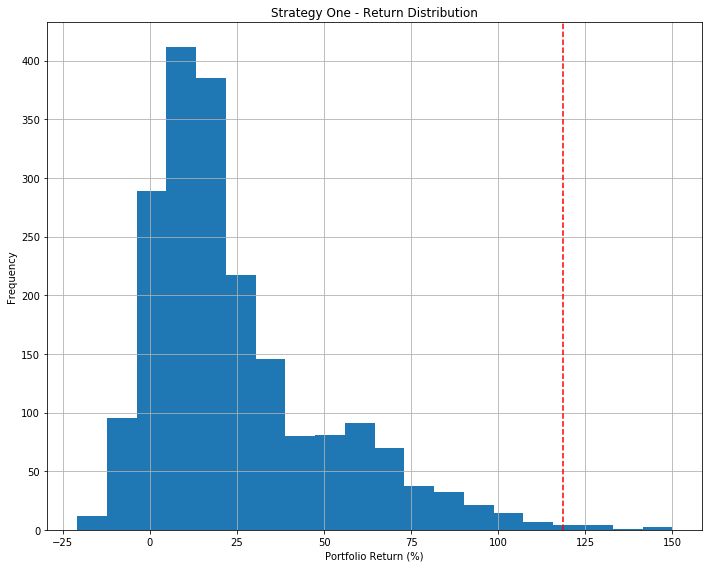

In [298]:
import statistics

print ("Strategy One Return - mean:{:.1f}%, std:{:.1f}%".format(statistics.mean(returns),statistics.stdev(returns)))
plt.figure(figsize=(10, 6))
num_bins = 20
plt.hist(returns,num_bins)
plt.xlabel('Portfolio Return (%)')
plt.ylabel("Frequency")
plt.title("Strategy One - Return Distribution")

plt.axvline(x=118.613, color="red", linestyle='--')
plt.grid(True)
plt.tight_layout()

plt.show()

# Implement Strategy Two - Prune Losers & Reinvest in Winners

In [305]:
num_iterations = 2000
returns = []
debug = False

for i in range(num_iterations):
    
    # Execute Strategy Two 

    portfolio = {}  # for storing portfolio info
    last = None   # to save a copy of the portfolio prior to rebalancing
    cash = START  # Start with $10M in cash

    for date, num_tickers, rebalance_period in zip(end_dates,portfolio_sizes, rebalance_periods):

        if debug:
            print('Portfolio: {}'.format(date))
        start, end = rebalance_period

        if last is None:  # Build the portfolio by investing starter cash evenly in a number of tickers

            if debug:
                print("Invest Evenly into {} tickers!".format(num_tickers))

            portfolio[date] = {}
            # Randomly select a set number of tickers from the prospect list (SHOTGUN)
            portfolio[date]['tickers'] = random_select(list(prospects[date].index), num_tickers)  
            portfolio[date]['num_shares'] = [0 for x in portfolio[date]['tickers']]

            # Invest cash evenly between the tickers
            invest = start_cash/num_tickers  
            portfolio[date]['num_shares'] = invest_evenly(portfolio[date]['tickers'], \
                                                         portfolio[date]['num_shares'], \
                                                         invest, start, end, debug=debug)

            last = portfolio[date]   # Save a copy of the portfolio for later iterations
            cash = 0  # No more cash left

        else:   # Rebalance portfolio - Let Winners run, Cut Losers Loose

            if debug:
                print("Let Winners run!")

            portfolio[date] = {}
            new_portfolio = {}
            loser_tickers = []
            loser_holdings = []

            # If a ticker in the portfolio is on the new prospect list, keep it as a Winner.
            # If a ticker is not on the new prospect list, sell its position for cash
            winners, losers = identify_winners(last['tickers'], list(prospects[date].index))
            
            if len(losers) is not 0:  # if there are losers
                
                # create new portfolio by pruning the losers
                new_portfolio, loser_tickers,loser_holdings = prune_losers(last, losers, debug=debug)  

                # Liquidate Losers for cash during rebalance period
                liquidation = liquidate(loser_tickers, loser_holdings, start, end, debug=debug)
                cash = liquidation
            else:
                new_portfolio = last  # no change to the portfolio
                cash = 0
            
            if debug:
                print('Winners: {}'.format(winners))
                print('Losers: {}'.format(losers))
                print('Cash harvested from Losers: ${:.2f}'.format(liquidation))   

           
            if cash > 0:
                # If there is cash left over, invest it evenly into the Winners
                
                num_winners = len(new_portfolio['tickers'])
                if debug:
                    print("Invest ${:.2f} into {} Winners!".format(cash, num_winners))

                # Invest cash evenly between the tickers
                invest = cash/num_winners  
                new_portfolio['num_shares'] = invest_evenly(new_portfolio['tickers'], \
                                                             new_portfolio['num_shares'], \
                                                             invest, start, end, debug=debug)
                cash = 0  # No more cash left

            # Merge Newbies and Winners into final portfolio        
            # portfolio[date]['tickers'] = winner_tickers + newbie_tickers
            # portfolio[date]['num_shares'] = winner_holdings + newbie_holdings
            portfolio[date] = new_portfolio
            
            last = portfolio[date].copy()   # Save portfolio for later iterations

    # Calculate value of the stock holdings on target date
    equity = portfolio_value(last['tickers'], last['num_shares'], target_date)
    total = equity + cash
    
    # Calculate and save portfolio return
    portfolio_return = (total/start_cash-1)*100
    returns.append(portfolio_return)

    print('Equity is valued at: ${:.2f}'.format(equity))
    print('Cash Position: ${:.2f}'.format(cash))
    print('Portfolio Total: ${:.2f}'.format(total))
    print('Portfolio appreciates by {:.1f} %'.format(portfolio_return))
    print('\n')

Equity is valued at: $21035716.53
Cash Position: $0.00
Portfolio Total: $21035716.53
Portfolio appreciates by 110.4 %


Equity is valued at: $20955655.49
Cash Position: $0.00
Portfolio Total: $20955655.49
Portfolio appreciates by 109.6 %


Equity is valued at: $15283812.63
Cash Position: $0.00
Portfolio Total: $15283812.63
Portfolio appreciates by 52.8 %


Equity is valued at: $9770609.13
Cash Position: $0.00
Portfolio Total: $9770609.13
Portfolio appreciates by -2.3 %


Equity is valued at: $52059706.92
Cash Position: $0.00
Portfolio Total: $52059706.92
Portfolio appreciates by 420.6 %


Equity is valued at: $29640646.49
Cash Position: $0.00
Portfolio Total: $29640646.49
Portfolio appreciates by 196.4 %


Equity is valued at: $26210122.17
Cash Position: $0.00
Portfolio Total: $26210122.17
Portfolio appreciates by 162.1 %


Equity is valued at: $14427336.14
Cash Position: $0.00
Portfolio Total: $14427336.14
Portfolio appreciates by 44.3 %


Equity is valued at: $13128048.14
Cash Positi

Equity is valued at: $51581803.28
Cash Position: $0.00
Portfolio Total: $51581803.28
Portfolio appreciates by 415.8 %


Equity is valued at: $14270942.43
Cash Position: $0.00
Portfolio Total: $14270942.43
Portfolio appreciates by 42.7 %


Equity is valued at: $23626117.59
Cash Position: $0.00
Portfolio Total: $23626117.59
Portfolio appreciates by 136.3 %


Equity is valued at: $16975727.58
Cash Position: $0.00
Portfolio Total: $16975727.58
Portfolio appreciates by 69.8 %


Equity is valued at: $12110046.44
Cash Position: $0.00
Portfolio Total: $12110046.44
Portfolio appreciates by 21.1 %


Equity is valued at: $16292820.91
Cash Position: $0.00
Portfolio Total: $16292820.91
Portfolio appreciates by 62.9 %


Equity is valued at: $20171855.91
Cash Position: $0.00
Portfolio Total: $20171855.91
Portfolio appreciates by 101.7 %


Equity is valued at: $10309603.26
Cash Position: $0.00
Portfolio Total: $10309603.26
Portfolio appreciates by 3.1 %


Equity is valued at: $8058287.01
Cash Position

Equity is valued at: $11333622.26
Cash Position: $0.00
Portfolio Total: $11333622.26
Portfolio appreciates by 13.3 %


Equity is valued at: $14737810.73
Cash Position: $0.00
Portfolio Total: $14737810.73
Portfolio appreciates by 47.4 %


Equity is valued at: $15604659.74
Cash Position: $0.00
Portfolio Total: $15604659.74
Portfolio appreciates by 56.0 %


Equity is valued at: $14846382.75
Cash Position: $0.00
Portfolio Total: $14846382.75
Portfolio appreciates by 48.5 %


Equity is valued at: $18211613.04
Cash Position: $0.00
Portfolio Total: $18211613.04
Portfolio appreciates by 82.1 %


Equity is valued at: $13661612.19
Cash Position: $0.00
Portfolio Total: $13661612.19
Portfolio appreciates by 36.6 %


Equity is valued at: $33967471.25
Cash Position: $0.00
Portfolio Total: $33967471.25
Portfolio appreciates by 239.7 %


Equity is valued at: $16899279.67
Cash Position: $0.00
Portfolio Total: $16899279.67
Portfolio appreciates by 69.0 %


Equity is valued at: $14758719.47
Cash Position

Equity is valued at: $17669995.01
Cash Position: $0.00
Portfolio Total: $17669995.01
Portfolio appreciates by 76.7 %


Equity is valued at: $21490187.69
Cash Position: $0.00
Portfolio Total: $21490187.69
Portfolio appreciates by 114.9 %


Equity is valued at: $18187472.10
Cash Position: $0.00
Portfolio Total: $18187472.10
Portfolio appreciates by 81.9 %


Equity is valued at: $29041988.60
Cash Position: $0.00
Portfolio Total: $29041988.60
Portfolio appreciates by 190.4 %


Equity is valued at: $15400694.50
Cash Position: $0.00
Portfolio Total: $15400694.50
Portfolio appreciates by 54.0 %


Equity is valued at: $14524035.00
Cash Position: $0.00
Portfolio Total: $14524035.00
Portfolio appreciates by 45.2 %


Equity is valued at: $8818519.81
Cash Position: $0.00
Portfolio Total: $8818519.81
Portfolio appreciates by -11.8 %


Equity is valued at: $33755282.14
Cash Position: $0.00
Portfolio Total: $33755282.14
Portfolio appreciates by 237.6 %


Equity is valued at: $15290827.02
Cash Positio

Equity is valued at: $20553973.77
Cash Position: $0.00
Portfolio Total: $20553973.77
Portfolio appreciates by 105.5 %


Equity is valued at: $19481036.19
Cash Position: $0.00
Portfolio Total: $19481036.19
Portfolio appreciates by 94.8 %


Equity is valued at: $18083229.92
Cash Position: $0.00
Portfolio Total: $18083229.92
Portfolio appreciates by 80.8 %


Equity is valued at: $10716566.21
Cash Position: $0.00
Portfolio Total: $10716566.21
Portfolio appreciates by 7.2 %


Equity is valued at: $13142984.53
Cash Position: $0.00
Portfolio Total: $13142984.53
Portfolio appreciates by 31.4 %


Equity is valued at: $13798652.19
Cash Position: $0.00
Portfolio Total: $13798652.19
Portfolio appreciates by 38.0 %


Equity is valued at: $10647580.00
Cash Position: $0.00
Portfolio Total: $10647580.00
Portfolio appreciates by 6.5 %


Equity is valued at: $9749669.55
Cash Position: $0.00
Portfolio Total: $9749669.55
Portfolio appreciates by -2.5 %


Equity is valued at: $16416178.18
Cash Position: $0

Equity is valued at: $12304013.86
Cash Position: $0.00
Portfolio Total: $12304013.86
Portfolio appreciates by 23.0 %


Equity is valued at: $17597198.37
Cash Position: $0.00
Portfolio Total: $17597198.37
Portfolio appreciates by 76.0 %


Equity is valued at: $11720982.00
Cash Position: $0.00
Portfolio Total: $11720982.00
Portfolio appreciates by 17.2 %


Equity is valued at: $15708639.51
Cash Position: $0.00
Portfolio Total: $15708639.51
Portfolio appreciates by 57.1 %


Equity is valued at: $18243806.25
Cash Position: $0.00
Portfolio Total: $18243806.25
Portfolio appreciates by 82.4 %


Equity is valued at: $17562829.91
Cash Position: $0.00
Portfolio Total: $17562829.91
Portfolio appreciates by 75.6 %


Equity is valued at: $11465962.66
Cash Position: $0.00
Portfolio Total: $11465962.66
Portfolio appreciates by 14.7 %


Equity is valued at: $15929529.95
Cash Position: $0.00
Portfolio Total: $15929529.95
Portfolio appreciates by 59.3 %


Equity is valued at: $13281425.39
Cash Position:

Equity is valued at: $12886485.97
Cash Position: $0.00
Portfolio Total: $12886485.97
Portfolio appreciates by 28.9 %


Equity is valued at: $16978371.81
Cash Position: $0.00
Portfolio Total: $16978371.81
Portfolio appreciates by 69.8 %


Equity is valued at: $13234250.06
Cash Position: $0.00
Portfolio Total: $13234250.06
Portfolio appreciates by 32.3 %


Equity is valued at: $21191500.60
Cash Position: $0.00
Portfolio Total: $21191500.60
Portfolio appreciates by 111.9 %


Equity is valued at: $21161633.12
Cash Position: $0.00
Portfolio Total: $21161633.12
Portfolio appreciates by 111.6 %


Equity is valued at: $22909406.77
Cash Position: $0.00
Portfolio Total: $22909406.77
Portfolio appreciates by 129.1 %


Equity is valued at: $14617237.84
Cash Position: $0.00
Portfolio Total: $14617237.84
Portfolio appreciates by 46.2 %


Equity is valued at: $10734048.73
Cash Position: $0.00
Portfolio Total: $10734048.73
Portfolio appreciates by 7.3 %


Equity is valued at: $16026403.49
Cash Positio

Equity is valued at: $14399613.14
Cash Position: $0.00
Portfolio Total: $14399613.14
Portfolio appreciates by 44.0 %


Equity is valued at: $14971858.07
Cash Position: $0.00
Portfolio Total: $14971858.07
Portfolio appreciates by 49.7 %


Equity is valued at: $21889874.40
Cash Position: $0.00
Portfolio Total: $21889874.40
Portfolio appreciates by 118.9 %


Equity is valued at: $19626841.61
Cash Position: $0.00
Portfolio Total: $19626841.61
Portfolio appreciates by 96.3 %


Equity is valued at: $21023696.34
Cash Position: $0.00
Portfolio Total: $21023696.34
Portfolio appreciates by 110.2 %


Equity is valued at: $12614303.17
Cash Position: $0.00
Portfolio Total: $12614303.17
Portfolio appreciates by 26.1 %


Equity is valued at: $11039289.19
Cash Position: $0.00
Portfolio Total: $11039289.19
Portfolio appreciates by 10.4 %


Equity is valued at: $17317675.40
Cash Position: $0.00
Portfolio Total: $17317675.40
Portfolio appreciates by 73.2 %


Equity is valued at: $16298435.06
Cash Positio

Equity is valued at: $9587793.86
Cash Position: $0.00
Portfolio Total: $9587793.86
Portfolio appreciates by -4.1 %


Equity is valued at: $18611530.08
Cash Position: $0.00
Portfolio Total: $18611530.08
Portfolio appreciates by 86.1 %


Equity is valued at: $9341018.42
Cash Position: $0.00
Portfolio Total: $9341018.42
Portfolio appreciates by -6.6 %


Equity is valued at: $20090208.68
Cash Position: $0.00
Portfolio Total: $20090208.68
Portfolio appreciates by 100.9 %


Equity is valued at: $18129223.72
Cash Position: $0.00
Portfolio Total: $18129223.72
Portfolio appreciates by 81.3 %


Equity is valued at: $12363818.21
Cash Position: $0.00
Portfolio Total: $12363818.21
Portfolio appreciates by 23.6 %


Equity is valued at: $12141906.68
Cash Position: $0.00
Portfolio Total: $12141906.68
Portfolio appreciates by 21.4 %


Equity is valued at: $13776069.21
Cash Position: $0.00
Portfolio Total: $13776069.21
Portfolio appreciates by 37.8 %


Equity is valued at: $11685221.05
Cash Position: $0

Equity is valued at: $12552494.29
Cash Position: $0.00
Portfolio Total: $12552494.29
Portfolio appreciates by 25.5 %


Equity is valued at: $12785701.54
Cash Position: $0.00
Portfolio Total: $12785701.54
Portfolio appreciates by 27.9 %


Equity is valued at: $31644750.91
Cash Position: $0.00
Portfolio Total: $31644750.91
Portfolio appreciates by 216.4 %


Equity is valued at: $13283869.44
Cash Position: $0.00
Portfolio Total: $13283869.44
Portfolio appreciates by 32.8 %


Equity is valued at: $37853820.37
Cash Position: $0.00
Portfolio Total: $37853820.37
Portfolio appreciates by 278.5 %


Equity is valued at: $18767149.95
Cash Position: $0.00
Portfolio Total: $18767149.95
Portfolio appreciates by 87.7 %


Equity is valued at: $12763408.13
Cash Position: $0.00
Portfolio Total: $12763408.13
Portfolio appreciates by 27.6 %


Equity is valued at: $19956217.53
Cash Position: $0.00
Portfolio Total: $19956217.53
Portfolio appreciates by 99.6 %


Equity is valued at: $23144311.91
Cash Positio

Equity is valued at: $11795306.12
Cash Position: $0.00
Portfolio Total: $11795306.12
Portfolio appreciates by 18.0 %


Equity is valued at: $13558684.05
Cash Position: $0.00
Portfolio Total: $13558684.05
Portfolio appreciates by 35.6 %


Equity is valued at: $14490774.35
Cash Position: $0.00
Portfolio Total: $14490774.35
Portfolio appreciates by 44.9 %


Equity is valued at: $14395774.52
Cash Position: $0.00
Portfolio Total: $14395774.52
Portfolio appreciates by 44.0 %


Equity is valued at: $12961674.40
Cash Position: $0.00
Portfolio Total: $12961674.40
Portfolio appreciates by 29.6 %


Equity is valued at: $13674275.08
Cash Position: $0.00
Portfolio Total: $13674275.08
Portfolio appreciates by 36.7 %


Equity is valued at: $12800312.49
Cash Position: $0.00
Portfolio Total: $12800312.49
Portfolio appreciates by 28.0 %


Equity is valued at: $13099618.31
Cash Position: $0.00
Portfolio Total: $13099618.31
Portfolio appreciates by 31.0 %


Equity is valued at: $14119007.68
Cash Position:

Equity is valued at: $18834713.96
Cash Position: $0.00
Portfolio Total: $18834713.96
Portfolio appreciates by 88.3 %


Equity is valued at: $13129551.33
Cash Position: $0.00
Portfolio Total: $13129551.33
Portfolio appreciates by 31.3 %


Equity is valued at: $16962841.67
Cash Position: $0.00
Portfolio Total: $16962841.67
Portfolio appreciates by 69.6 %


Equity is valued at: $12499382.97
Cash Position: $0.00
Portfolio Total: $12499382.97
Portfolio appreciates by 25.0 %


Equity is valued at: $17730471.01
Cash Position: $0.00
Portfolio Total: $17730471.01
Portfolio appreciates by 77.3 %


Equity is valued at: $12631327.02
Cash Position: $0.00
Portfolio Total: $12631327.02
Portfolio appreciates by 26.3 %


Equity is valued at: $21033154.65
Cash Position: $0.00
Portfolio Total: $21033154.65
Portfolio appreciates by 110.3 %


Equity is valued at: $10269081.22
Cash Position: $0.00
Portfolio Total: $10269081.22
Portfolio appreciates by 2.7 %


Equity is valued at: $14231925.90
Cash Position:

Equity is valued at: $13720237.99
Cash Position: $0.00
Portfolio Total: $13720237.99
Portfolio appreciates by 37.2 %


Equity is valued at: $11088252.07
Cash Position: $0.00
Portfolio Total: $11088252.07
Portfolio appreciates by 10.9 %


Equity is valued at: $17320756.51
Cash Position: $0.00
Portfolio Total: $17320756.51
Portfolio appreciates by 73.2 %


Equity is valued at: $11637308.54
Cash Position: $0.00
Portfolio Total: $11637308.54
Portfolio appreciates by 16.4 %


Equity is valued at: $24407031.54
Cash Position: $0.00
Portfolio Total: $24407031.54
Portfolio appreciates by 144.1 %


Equity is valued at: $43647750.67
Cash Position: $0.00
Portfolio Total: $43647750.67
Portfolio appreciates by 336.5 %


Equity is valued at: $15196134.57
Cash Position: $0.00
Portfolio Total: $15196134.57
Portfolio appreciates by 52.0 %


Equity is valued at: $11151935.86
Cash Position: $0.00
Portfolio Total: $11151935.86
Portfolio appreciates by 11.5 %


Equity is valued at: $13140408.45
Cash Positio

Equity is valued at: $14733341.40
Cash Position: $0.00
Portfolio Total: $14733341.40
Portfolio appreciates by 47.3 %


Equity is valued at: $16234944.50
Cash Position: $0.00
Portfolio Total: $16234944.50
Portfolio appreciates by 62.3 %


Equity is valued at: $15476707.49
Cash Position: $0.00
Portfolio Total: $15476707.49
Portfolio appreciates by 54.8 %


Equity is valued at: $14927419.99
Cash Position: $0.00
Portfolio Total: $14927419.99
Portfolio appreciates by 49.3 %


Equity is valued at: $11043784.66
Cash Position: $0.00
Portfolio Total: $11043784.66
Portfolio appreciates by 10.4 %


Equity is valued at: $21470965.14
Cash Position: $0.00
Portfolio Total: $21470965.14
Portfolio appreciates by 114.7 %


Equity is valued at: $18298520.44
Cash Position: $0.00
Portfolio Total: $18298520.44
Portfolio appreciates by 83.0 %


Equity is valued at: $23740107.96
Cash Position: $0.00
Portfolio Total: $23740107.96
Portfolio appreciates by 137.4 %


Equity is valued at: $12370028.43
Cash Positio

Equity is valued at: $16327756.67
Cash Position: $0.00
Portfolio Total: $16327756.67
Portfolio appreciates by 63.3 %


Equity is valued at: $12578671.47
Cash Position: $0.00
Portfolio Total: $12578671.47
Portfolio appreciates by 25.8 %


Equity is valued at: $12555876.65
Cash Position: $0.00
Portfolio Total: $12555876.65
Portfolio appreciates by 25.6 %


Equity is valued at: $20316597.00
Cash Position: $0.00
Portfolio Total: $20316597.00
Portfolio appreciates by 103.2 %


Equity is valued at: $19102193.20
Cash Position: $0.00
Portfolio Total: $19102193.20
Portfolio appreciates by 91.0 %


Equity is valued at: $12194746.32
Cash Position: $0.00
Portfolio Total: $12194746.32
Portfolio appreciates by 21.9 %


Equity is valued at: $14936147.17
Cash Position: $0.00
Portfolio Total: $14936147.17
Portfolio appreciates by 49.4 %


Equity is valued at: $15934901.97
Cash Position: $0.00
Portfolio Total: $15934901.97
Portfolio appreciates by 59.3 %


Equity is valued at: $9502420.51
Cash Position:

Equity is valued at: $10054267.23
Cash Position: $0.00
Portfolio Total: $10054267.23
Portfolio appreciates by 0.5 %


Equity is valued at: $18765923.85
Cash Position: $0.00
Portfolio Total: $18765923.85
Portfolio appreciates by 87.7 %


Equity is valued at: $20129489.46
Cash Position: $0.00
Portfolio Total: $20129489.46
Portfolio appreciates by 101.3 %


Equity is valued at: $14922509.48
Cash Position: $0.00
Portfolio Total: $14922509.48
Portfolio appreciates by 49.2 %


Equity is valued at: $17466558.54
Cash Position: $0.00
Portfolio Total: $17466558.54
Portfolio appreciates by 74.7 %


Equity is valued at: $19762294.65
Cash Position: $0.00
Portfolio Total: $19762294.65
Portfolio appreciates by 97.6 %


Equity is valued at: $11511316.89
Cash Position: $0.00
Portfolio Total: $11511316.89
Portfolio appreciates by 15.1 %


Equity is valued at: $15105292.38
Cash Position: $0.00
Portfolio Total: $15105292.38
Portfolio appreciates by 51.1 %


Equity is valued at: $14385969.90
Cash Position:

Equity is valued at: $20469731.62
Cash Position: $0.00
Portfolio Total: $20469731.62
Portfolio appreciates by 104.7 %


Equity is valued at: $13533887.07
Cash Position: $0.00
Portfolio Total: $13533887.07
Portfolio appreciates by 35.3 %


Equity is valued at: $11666438.40
Cash Position: $0.00
Portfolio Total: $11666438.40
Portfolio appreciates by 16.7 %


Equity is valued at: $14262398.06
Cash Position: $0.00
Portfolio Total: $14262398.06
Portfolio appreciates by 42.6 %


Equity is valued at: $19871663.87
Cash Position: $0.00
Portfolio Total: $19871663.87
Portfolio appreciates by 98.7 %


Equity is valued at: $44649465.02
Cash Position: $0.00
Portfolio Total: $44649465.02
Portfolio appreciates by 346.5 %


Equity is valued at: $47590295.82
Cash Position: $0.00
Portfolio Total: $47590295.82
Portfolio appreciates by 375.9 %


Equity is valued at: $18021736.02
Cash Position: $0.00
Portfolio Total: $18021736.02
Portfolio appreciates by 80.2 %


Equity is valued at: $9686529.84
Cash Positio

Equity is valued at: $21425620.08
Cash Position: $0.00
Portfolio Total: $21425620.08
Portfolio appreciates by 114.3 %


Equity is valued at: $22885211.07
Cash Position: $0.00
Portfolio Total: $22885211.07
Portfolio appreciates by 128.9 %


Equity is valued at: $19372728.60
Cash Position: $0.00
Portfolio Total: $19372728.60
Portfolio appreciates by 93.7 %


Equity is valued at: $14566636.15
Cash Position: $0.00
Portfolio Total: $14566636.15
Portfolio appreciates by 45.7 %


Equity is valued at: $15726391.16
Cash Position: $0.00
Portfolio Total: $15726391.16
Portfolio appreciates by 57.3 %


Equity is valued at: $25109034.69
Cash Position: $0.00
Portfolio Total: $25109034.69
Portfolio appreciates by 151.1 %


Equity is valued at: $12400167.83
Cash Position: $0.00
Portfolio Total: $12400167.83
Portfolio appreciates by 24.0 %


Equity is valued at: $17830267.07
Cash Position: $0.00
Portfolio Total: $17830267.07
Portfolio appreciates by 78.3 %


Equity is valued at: $14792145.02
Cash Positi

Equity is valued at: $39394605.53
Cash Position: $0.00
Portfolio Total: $39394605.53
Portfolio appreciates by 293.9 %


Equity is valued at: $47819334.43
Cash Position: $0.00
Portfolio Total: $47819334.43
Portfolio appreciates by 378.2 %


Equity is valued at: $12302563.83
Cash Position: $0.00
Portfolio Total: $12302563.83
Portfolio appreciates by 23.0 %


Equity is valued at: $11281918.29
Cash Position: $0.00
Portfolio Total: $11281918.29
Portfolio appreciates by 12.8 %


Equity is valued at: $12400483.37
Cash Position: $0.00
Portfolio Total: $12400483.37
Portfolio appreciates by 24.0 %


Equity is valued at: $20548221.11
Cash Position: $0.00
Portfolio Total: $20548221.11
Portfolio appreciates by 105.5 %


Equity is valued at: $20473796.98
Cash Position: $0.00
Portfolio Total: $20473796.98
Portfolio appreciates by 104.7 %


Equity is valued at: $20545942.78
Cash Position: $0.00
Portfolio Total: $20545942.78
Portfolio appreciates by 105.5 %


Equity is valued at: $19278706.21
Cash Posi

Equity is valued at: $20025214.63
Cash Position: $0.00
Portfolio Total: $20025214.63
Portfolio appreciates by 100.3 %


Equity is valued at: $70532967.64
Cash Position: $0.00
Portfolio Total: $70532967.64
Portfolio appreciates by 605.3 %


Equity is valued at: $27631462.08
Cash Position: $0.00
Portfolio Total: $27631462.08
Portfolio appreciates by 176.3 %


Equity is valued at: $17897254.35
Cash Position: $0.00
Portfolio Total: $17897254.35
Portfolio appreciates by 79.0 %


Equity is valued at: $12320004.32
Cash Position: $0.00
Portfolio Total: $12320004.32
Portfolio appreciates by 23.2 %


Equity is valued at: $15071645.02
Cash Position: $0.00
Portfolio Total: $15071645.02
Portfolio appreciates by 50.7 %


Equity is valued at: $31489409.02
Cash Position: $0.00
Portfolio Total: $31489409.02
Portfolio appreciates by 214.9 %


Equity is valued at: $27882443.00
Cash Position: $0.00
Portfolio Total: $27882443.00
Portfolio appreciates by 178.8 %


Equity is valued at: $13607661.09
Cash Posi

Equity is valued at: $17467388.79
Cash Position: $0.00
Portfolio Total: $17467388.79
Portfolio appreciates by 74.7 %


Equity is valued at: $16726026.04
Cash Position: $0.00
Portfolio Total: $16726026.04
Portfolio appreciates by 67.3 %


Equity is valued at: $12702623.97
Cash Position: $0.00
Portfolio Total: $12702623.97
Portfolio appreciates by 27.0 %


Equity is valued at: $42581173.59
Cash Position: $0.00
Portfolio Total: $42581173.59
Portfolio appreciates by 325.8 %


Equity is valued at: $19844539.71
Cash Position: $0.00
Portfolio Total: $19844539.71
Portfolio appreciates by 98.4 %


Equity is valued at: $20113562.51
Cash Position: $0.00
Portfolio Total: $20113562.51
Portfolio appreciates by 101.1 %


Equity is valued at: $16779642.72
Cash Position: $0.00
Portfolio Total: $16779642.72
Portfolio appreciates by 67.8 %


Equity is valued at: $39423186.72
Cash Position: $0.00
Portfolio Total: $39423186.72
Portfolio appreciates by 294.2 %


Equity is valued at: $11135263.12
Cash Positi

Equity is valued at: $17505654.19
Cash Position: $0.00
Portfolio Total: $17505654.19
Portfolio appreciates by 75.1 %


Equity is valued at: $11857589.80
Cash Position: $0.00
Portfolio Total: $11857589.80
Portfolio appreciates by 18.6 %


Equity is valued at: $20811872.85
Cash Position: $0.00
Portfolio Total: $20811872.85
Portfolio appreciates by 108.1 %


Equity is valued at: $16187765.74
Cash Position: $0.00
Portfolio Total: $16187765.74
Portfolio appreciates by 61.9 %


Equity is valued at: $16845541.42
Cash Position: $0.00
Portfolio Total: $16845541.42
Portfolio appreciates by 68.5 %


Equity is valued at: $31512824.67
Cash Position: $0.00
Portfolio Total: $31512824.67
Portfolio appreciates by 215.1 %


Equity is valued at: $18509607.48
Cash Position: $0.00
Portfolio Total: $18509607.48
Portfolio appreciates by 85.1 %


Equity is valued at: $13932264.52
Cash Position: $0.00
Portfolio Total: $13932264.52
Portfolio appreciates by 39.3 %


Equity is valued at: $22980298.12
Cash Positio

Equity is valued at: $14850079.26
Cash Position: $0.00
Portfolio Total: $14850079.26
Portfolio appreciates by 48.5 %


Equity is valued at: $9494141.00
Cash Position: $0.00
Portfolio Total: $9494141.00
Portfolio appreciates by -5.1 %


Equity is valued at: $11373253.01
Cash Position: $0.00
Portfolio Total: $11373253.01
Portfolio appreciates by 13.7 %


Equity is valued at: $29218579.77
Cash Position: $0.00
Portfolio Total: $29218579.77
Portfolio appreciates by 192.2 %


Equity is valued at: $13390038.44
Cash Position: $0.00
Portfolio Total: $13390038.44
Portfolio appreciates by 33.9 %


Equity is valued at: $12397514.02
Cash Position: $0.00
Portfolio Total: $12397514.02
Portfolio appreciates by 24.0 %


Equity is valued at: $18744137.18
Cash Position: $0.00
Portfolio Total: $18744137.18
Portfolio appreciates by 87.4 %


Equity is valued at: $15596255.55
Cash Position: $0.00
Portfolio Total: $15596255.55
Portfolio appreciates by 56.0 %


Equity is valued at: $18282689.09
Cash Position: 

Equity is valued at: $11058542.71
Cash Position: $0.00
Portfolio Total: $11058542.71
Portfolio appreciates by 10.6 %


Equity is valued at: $23628631.77
Cash Position: $0.00
Portfolio Total: $23628631.77
Portfolio appreciates by 136.3 %


Equity is valued at: $18055800.64
Cash Position: $0.00
Portfolio Total: $18055800.64
Portfolio appreciates by 80.6 %


Equity is valued at: $9663603.27
Cash Position: $0.00
Portfolio Total: $9663603.27
Portfolio appreciates by -3.4 %


Equity is valued at: $20014221.24
Cash Position: $0.00
Portfolio Total: $20014221.24
Portfolio appreciates by 100.1 %


Equity is valued at: $20933090.12
Cash Position: $0.00
Portfolio Total: $20933090.12
Portfolio appreciates by 109.3 %


Equity is valued at: $14244884.52
Cash Position: $0.00
Portfolio Total: $14244884.52
Portfolio appreciates by 42.4 %


Equity is valued at: $11941825.95
Cash Position: $0.00
Portfolio Total: $11941825.95
Portfolio appreciates by 19.4 %


Equity is valued at: $11681933.58
Cash Position

Equity is valued at: $17719510.92
Cash Position: $0.00
Portfolio Total: $17719510.92
Portfolio appreciates by 77.2 %


Equity is valued at: $18037224.86
Cash Position: $0.00
Portfolio Total: $18037224.86
Portfolio appreciates by 80.4 %


Equity is valued at: $22568823.74
Cash Position: $0.00
Portfolio Total: $22568823.74
Portfolio appreciates by 125.7 %


Equity is valued at: $11878048.50
Cash Position: $0.00
Portfolio Total: $11878048.50
Portfolio appreciates by 18.8 %


Equity is valued at: $21476148.22
Cash Position: $0.00
Portfolio Total: $21476148.22
Portfolio appreciates by 114.8 %


Equity is valued at: $12781841.78
Cash Position: $0.00
Portfolio Total: $12781841.78
Portfolio appreciates by 27.8 %


Equity is valued at: $14720308.91
Cash Position: $0.00
Portfolio Total: $14720308.91
Portfolio appreciates by 47.2 %


Equity is valued at: $39671801.17
Cash Position: $0.00
Portfolio Total: $39671801.17
Portfolio appreciates by 296.7 %


Equity is valued at: $14364719.66
Cash Positi

Equity is valued at: $17075991.01
Cash Position: $0.00
Portfolio Total: $17075991.01
Portfolio appreciates by 70.8 %


Equity is valued at: $22300517.56
Cash Position: $0.00
Portfolio Total: $22300517.56
Portfolio appreciates by 123.0 %


Equity is valued at: $9908858.92
Cash Position: $0.00
Portfolio Total: $9908858.92
Portfolio appreciates by -0.9 %


Equity is valued at: $9333707.34
Cash Position: $0.00
Portfolio Total: $9333707.34
Portfolio appreciates by -6.7 %


Equity is valued at: $13754727.53
Cash Position: $0.00
Portfolio Total: $13754727.53
Portfolio appreciates by 37.5 %


Equity is valued at: $16925572.98
Cash Position: $0.00
Portfolio Total: $16925572.98
Portfolio appreciates by 69.3 %


Equity is valued at: $11177413.31
Cash Position: $0.00
Portfolio Total: $11177413.31
Portfolio appreciates by 11.8 %


Equity is valued at: $13002459.06
Cash Position: $0.00
Portfolio Total: $13002459.06
Portfolio appreciates by 30.0 %


Equity is valued at: $12217006.58
Cash Position: $0

Equity is valued at: $22279465.44
Cash Position: $0.00
Portfolio Total: $22279465.44
Portfolio appreciates by 122.8 %


Equity is valued at: $17507031.55
Cash Position: $0.00
Portfolio Total: $17507031.55
Portfolio appreciates by 75.1 %


Equity is valued at: $9650816.44
Cash Position: $0.00
Portfolio Total: $9650816.44
Portfolio appreciates by -3.5 %


Equity is valued at: $12020578.64
Cash Position: $0.00
Portfolio Total: $12020578.64
Portfolio appreciates by 20.2 %


Equity is valued at: $15279155.83
Cash Position: $0.00
Portfolio Total: $15279155.83
Portfolio appreciates by 52.8 %


Equity is valued at: $48678031.02
Cash Position: $0.00
Portfolio Total: $48678031.02
Portfolio appreciates by 386.8 %


Equity is valued at: $15074705.40
Cash Position: $0.00
Portfolio Total: $15074705.40
Portfolio appreciates by 50.7 %


Equity is valued at: $23074073.56
Cash Position: $0.00
Portfolio Total: $23074073.56
Portfolio appreciates by 130.7 %


Equity is valued at: $16172208.56
Cash Position

Equity is valued at: $44690803.89
Cash Position: $0.00
Portfolio Total: $44690803.89
Portfolio appreciates by 346.9 %


Equity is valued at: $18226561.30
Cash Position: $0.00
Portfolio Total: $18226561.30
Portfolio appreciates by 82.3 %


Equity is valued at: $13377624.25
Cash Position: $0.00
Portfolio Total: $13377624.25
Portfolio appreciates by 33.8 %


Equity is valued at: $15618731.67
Cash Position: $0.00
Portfolio Total: $15618731.67
Portfolio appreciates by 56.2 %


Equity is valued at: $13887874.50
Cash Position: $0.00
Portfolio Total: $13887874.50
Portfolio appreciates by 38.9 %


Equity is valued at: $53743640.40
Cash Position: $0.00
Portfolio Total: $53743640.40
Portfolio appreciates by 437.4 %


Equity is valued at: $43652948.83
Cash Position: $0.00
Portfolio Total: $43652948.83
Portfolio appreciates by 336.5 %


Equity is valued at: $13892364.80
Cash Position: $0.00
Portfolio Total: $13892364.80
Portfolio appreciates by 38.9 %


Equity is valued at: $18174634.21
Cash Positi

Equity is valued at: $12161905.33
Cash Position: $0.00
Portfolio Total: $12161905.33
Portfolio appreciates by 21.6 %


Equity is valued at: $13975282.83
Cash Position: $0.00
Portfolio Total: $13975282.83
Portfolio appreciates by 39.8 %


Equity is valued at: $15927620.93
Cash Position: $0.00
Portfolio Total: $15927620.93
Portfolio appreciates by 59.3 %


Equity is valued at: $11843051.29
Cash Position: $0.00
Portfolio Total: $11843051.29
Portfolio appreciates by 18.4 %


Equity is valued at: $16779774.74
Cash Position: $0.00
Portfolio Total: $16779774.74
Portfolio appreciates by 67.8 %


Equity is valued at: $11648625.02
Cash Position: $0.00
Portfolio Total: $11648625.02
Portfolio appreciates by 16.5 %


Equity is valued at: $9391670.72
Cash Position: $0.00
Portfolio Total: $9391670.72
Portfolio appreciates by -6.1 %


Equity is valued at: $15679883.05
Cash Position: $0.00
Portfolio Total: $15679883.05
Portfolio appreciates by 56.8 %


Equity is valued at: $12955193.20
Cash Position: $

Strategy One Return - mean:82.6%, std:88.3%


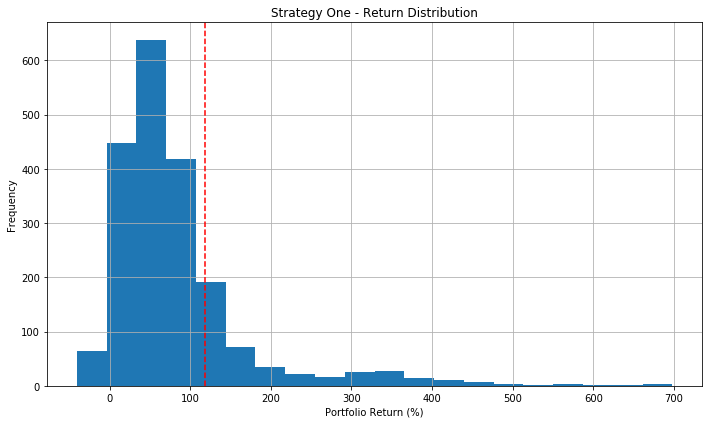

In [307]:
import statistics

print ("Strategy One Return - mean:{:.1f}%, std:{:.1f}%".format(statistics.mean(returns),statistics.stdev(returns)))
plt.figure(figsize=(10, 6))
num_bins = 20
plt.hist(returns,num_bins)
plt.xlabel('Portfolio Return (%)')
plt.ylabel("Frequency")
plt.title("Strategy One - Return Distribution")

plt.axvline(x=118.613, color="red", linestyle='--')
plt.grid(True)
plt.tight_layout()

plt.show()

# Strategy Three - Prune Losers; Reinvest in Winners and Newbies

In [355]:
num_iterations = 2000
returns = []
debug = False

for i in range(num_iterations):
    
    # Execute Strategy Three 

    portfolio = {}  # for storing portfolio info
    last = None   # to save a copy of the portfolio prior to rebalancing
    cash = START  # Start with $10M in cash

    for date, num_tickers, rebalance_period in zip(end_dates,portfolio_sizes, rebalance_periods):

        if debug:
            print('Portfolio: {}'.format(date))
        start, end = rebalance_period

        if last is None:  # Build the portfolio by investing starter cash evenly in a number of tickers

            if debug:
                print("Invest Evenly into {} tickers!".format(num_tickers))

            portfolio[date] = {}
            # Randomly select a set number of tickers from the prospect list (SHOTGUN)
            portfolio[date]['tickers'] = random_select(list(prospects[date].index), num_tickers)  
            portfolio[date]['num_shares'] = [0 for x in portfolio[date]['tickers']]

            # Invest cash evenly between the tickers
            invest = start_cash/num_tickers  
            portfolio[date]['num_shares'] = invest_evenly(portfolio[date]['tickers'], \
                                                         portfolio[date]['num_shares'], \
                                                         invest, start, end, debug=debug)

            last = portfolio[date]   # Save a copy of the portfolio for later iterations
            cash = 0  # No more cash left

        else:   # Rebalance portfolio - Let Winners run, Cut Losers Loose

            if debug:
                print("Let Winners run!")

            portfolio[date] = {}
            new_portfolio = {}
            loser_tickers = []
            loser_holdings = []
            newbie_tickers = []
            newbie_holdings = []

            # If a ticker in the portfolio is on the new prospect list, keep it as a Winner.
            # If a ticker is not on the new prospect list, sell its position for cash
            winners, losers = identify_winners(last['tickers'], list(prospects[date].index))
            
            if len(losers) is 0:  # if there are no losers
                new_portfolio = last  # no change to the portfolio
                cash = 0
                if debug:
                    print('No change to Portfolio.')
                    print('Winners: {}'.format(winners))
            else:    
                # create new portfolio by pruning the losers
                new_portfolio, loser_tickers,loser_holdings = prune_losers(last, losers, debug=debug)  

                # Liquidate Losers for cash during rebalance period
                cash= liquidate(loser_tickers, loser_holdings, start, end, debug=debug)

                if debug:
                    print('Winners: {}'.format(winners))
                    print('Losers: {}'.format(losers))
                    print('Cash harvested from Losers: ${:.2f}'.format(cash))   
          
                if len(winners) >= num_tickers:
                    # If number of winners exceed the target ticker numbers
                    # Skip investing into newbies, cash will be reinvested into Winners
                    if debug:
                        print("{} Winners. No need for new prospects!".format(len(winners)))

                else:
                    # Pick newbies from prospect list and invest into them.
                    # If there is cash left over, it will be reinvested into Winners
                    
                    num_newbies = num_tickers - len(winners)
                    standard_invest = START/num_tickers  # standard amount to invest per ticker 
                    available_invest = cash/num_newbies   # available amount to invest per ticker

                    if available_invest <= standard_invest:
                        # If available amount per ticker is less than standard amount
                        # Then simply invest what is available
                        invest = available_invest
                        cash = 0  # then there will be no left-over cash
                        if debug:
                            print('No extra cash!')
                    else:
                        # If available amount per ticker is more than standard amount
                        # Then invest the standard amount.
                        invest = standard_invest
                        cash -= invest * num_newbies  # There is left-over cash
                        if debug:
                            print('Extra cash!')

                    # Randomly select new tickers from the prospect list
                    newbie_tickers = random_select(list(prospects[date].index), num_newbies, winners)
                    newbie_holdings = [0 for x in newbie_tickers]

                    newbie_holdings = invest_evenly(newbie_tickers, newbie_holdings, \
                                                             invest, start, end, debug=debug)                
           
            if cash > 0:
                # If there is cash left over, invest it evenly into the Winners
                
                num_winners = len(new_portfolio['tickers'])
                if debug:
                    print("Invest ${:.2f} into {} Winners!".format(cash, num_winners))

                # Invest cash evenly between the tickers
                invest = cash/num_winners  
                new_portfolio['num_shares'] = invest_evenly(new_portfolio['tickers'],new_portfolio['num_shares'], \
                                                             invest, start, end, debug=debug)
                cash = 0  # No more cash left

            # Merge Newbies and Winners into final portfolio 
            if debug:
                print('Merge:')
                print('Newbies:{}'.format(newbie_tickers))
                print('Winners:{}'.format(new_portfolio['tickers']))
                print('Num Tickers:{}'.format(len(newbie_tickers)+len(new_portfolio['tickers'])))
            
            portfolio[date]['tickers'] = new_portfolio['tickers'] + newbie_tickers
            portfolio[date]['num_shares'] = new_portfolio['num_shares'] + newbie_holdings
            
            last = portfolio[date].copy()   # Save portfolio for later iterations

    # Calculate value of the stock holdings on target date
    equity = portfolio_value(last['tickers'], last['num_shares'], target_date)
    total = equity + cash
    
    # Calculate and save portfolio return
    portfolio_return = (total/start_cash-1)*100
    returns.append(portfolio_return)

    print('Equity is valued at: ${:.2f}'.format(equity))
    print('Cash Position: ${:.2f}'.format(cash))
    print('Portfolio Total: ${:.2f}'.format(total))
    print('Portfolio appreciates by {:.1f} %'.format(portfolio_return))
    print('\n')

Equity is valued at: $12899912.21
Cash Position: $0.00
Portfolio Total: $12899912.21
Portfolio appreciates by 29.0 %


Equity is valued at: $17182264.00
Cash Position: $0.00
Portfolio Total: $17182264.00
Portfolio appreciates by 71.8 %


Equity is valued at: $16325419.68
Cash Position: $0.00
Portfolio Total: $16325419.68
Portfolio appreciates by 63.3 %


Equity is valued at: $13366316.59
Cash Position: $0.00
Portfolio Total: $13366316.59
Portfolio appreciates by 33.7 %


Equity is valued at: $26146692.64
Cash Position: $0.00
Portfolio Total: $26146692.64
Portfolio appreciates by 161.5 %


Equity is valued at: $25540074.03
Cash Position: $0.00
Portfolio Total: $25540074.03
Portfolio appreciates by 155.4 %


Equity is valued at: $14905685.77
Cash Position: $0.00
Portfolio Total: $14905685.77
Portfolio appreciates by 49.1 %


Equity is valued at: $20257577.53
Cash Position: $0.00
Portfolio Total: $20257577.53
Portfolio appreciates by 102.6 %


Equity is valued at: $17167008.73
Cash Positi

Equity is valued at: $15216582.55
Cash Position: $0.00
Portfolio Total: $15216582.55
Portfolio appreciates by 52.2 %


Equity is valued at: $13818653.53
Cash Position: $0.00
Portfolio Total: $13818653.53
Portfolio appreciates by 38.2 %


Equity is valued at: $16358661.07
Cash Position: $0.00
Portfolio Total: $16358661.07
Portfolio appreciates by 63.6 %


Equity is valued at: $13534434.77
Cash Position: $0.00
Portfolio Total: $13534434.77
Portfolio appreciates by 35.3 %


Equity is valued at: $20984131.91
Cash Position: $0.00
Portfolio Total: $20984131.91
Portfolio appreciates by 109.8 %


Equity is valued at: $20067854.97
Cash Position: $0.00
Portfolio Total: $20067854.97
Portfolio appreciates by 100.7 %


Equity is valued at: $23155381.10
Cash Position: $0.00
Portfolio Total: $23155381.10
Portfolio appreciates by 131.6 %


Equity is valued at: $13953768.11
Cash Position: $0.00
Portfolio Total: $13953768.11
Portfolio appreciates by 39.5 %


Equity is valued at: $18331483.32
Cash Positi

Equity is valued at: $15763512.93
Cash Position: $0.00
Portfolio Total: $15763512.93
Portfolio appreciates by 57.6 %


Equity is valued at: $16071023.34
Cash Position: $0.00
Portfolio Total: $16071023.34
Portfolio appreciates by 60.7 %


Equity is valued at: $21943228.43
Cash Position: $0.00
Portfolio Total: $21943228.43
Portfolio appreciates by 119.4 %


Equity is valued at: $31845018.01
Cash Position: $0.00
Portfolio Total: $31845018.01
Portfolio appreciates by 218.5 %


Equity is valued at: $17877008.28
Cash Position: $0.00
Portfolio Total: $17877008.28
Portfolio appreciates by 78.8 %


Equity is valued at: $22872110.15
Cash Position: $0.00
Portfolio Total: $22872110.15
Portfolio appreciates by 128.7 %


Equity is valued at: $15154872.04
Cash Position: $0.00
Portfolio Total: $15154872.04
Portfolio appreciates by 51.5 %


Equity is valued at: $16632373.78
Cash Position: $0.00
Portfolio Total: $16632373.78
Portfolio appreciates by 66.3 %


Equity is valued at: $15448612.29
Cash Positi

Equity is valued at: $15580294.82
Cash Position: $0.00
Portfolio Total: $15580294.82
Portfolio appreciates by 55.8 %


Equity is valued at: $15365613.15
Cash Position: $0.00
Portfolio Total: $15365613.15
Portfolio appreciates by 53.7 %


Equity is valued at: $24550812.50
Cash Position: $0.00
Portfolio Total: $24550812.50
Portfolio appreciates by 145.5 %


Equity is valued at: $15185761.42
Cash Position: $0.00
Portfolio Total: $15185761.42
Portfolio appreciates by 51.9 %


Equity is valued at: $27128377.87
Cash Position: $0.00
Portfolio Total: $27128377.87
Portfolio appreciates by 171.3 %


Equity is valued at: $17430360.34
Cash Position: $0.00
Portfolio Total: $17430360.34
Portfolio appreciates by 74.3 %


Equity is valued at: $18132929.73
Cash Position: $0.00
Portfolio Total: $18132929.73
Portfolio appreciates by 81.3 %


Equity is valued at: $32294112.26
Cash Position: $0.00
Portfolio Total: $32294112.26
Portfolio appreciates by 222.9 %


Equity is valued at: $14871870.18
Cash Positi

Equity is valued at: $19706716.12
Cash Position: $0.00
Portfolio Total: $19706716.12
Portfolio appreciates by 97.1 %


Equity is valued at: $13863733.34
Cash Position: $0.00
Portfolio Total: $13863733.34
Portfolio appreciates by 38.6 %


Equity is valued at: $18493355.12
Cash Position: $0.00
Portfolio Total: $18493355.12
Portfolio appreciates by 84.9 %


Equity is valued at: $16614423.91
Cash Position: $0.00
Portfolio Total: $16614423.91
Portfolio appreciates by 66.1 %


Equity is valued at: $16447367.31
Cash Position: $0.00
Portfolio Total: $16447367.31
Portfolio appreciates by 64.5 %


Equity is valued at: $12189155.95
Cash Position: $0.00
Portfolio Total: $12189155.95
Portfolio appreciates by 21.9 %


Equity is valued at: $16995030.93
Cash Position: $0.00
Portfolio Total: $16995030.93
Portfolio appreciates by 70.0 %


Equity is valued at: $12914008.88
Cash Position: $0.00
Portfolio Total: $12914008.88
Portfolio appreciates by 29.1 %


Equity is valued at: $18995310.76
Cash Position:

Equity is valued at: $14694106.33
Cash Position: $0.00
Portfolio Total: $14694106.33
Portfolio appreciates by 46.9 %


Equity is valued at: $28280849.90
Cash Position: $0.00
Portfolio Total: $28280849.90
Portfolio appreciates by 182.8 %


Equity is valued at: $14737731.42
Cash Position: $0.00
Portfolio Total: $14737731.42
Portfolio appreciates by 47.4 %


Equity is valued at: $15382134.21
Cash Position: $0.00
Portfolio Total: $15382134.21
Portfolio appreciates by 53.8 %


Equity is valued at: $15066046.94
Cash Position: $0.00
Portfolio Total: $15066046.94
Portfolio appreciates by 50.7 %


Equity is valued at: $13178256.65
Cash Position: $0.00
Portfolio Total: $13178256.65
Portfolio appreciates by 31.8 %


Equity is valued at: $15422948.87
Cash Position: $0.00
Portfolio Total: $15422948.87
Portfolio appreciates by 54.2 %


Equity is valued at: $17100829.73
Cash Position: $0.00
Portfolio Total: $17100829.73
Portfolio appreciates by 71.0 %


Equity is valued at: $14308236.78
Cash Position

Equity is valued at: $16096280.80
Cash Position: $0.00
Portfolio Total: $16096280.80
Portfolio appreciates by 61.0 %


Equity is valued at: $24487494.45
Cash Position: $0.00
Portfolio Total: $24487494.45
Portfolio appreciates by 144.9 %


Equity is valued at: $16899878.86
Cash Position: $0.00
Portfolio Total: $16899878.86
Portfolio appreciates by 69.0 %


Equity is valued at: $14793739.23
Cash Position: $0.00
Portfolio Total: $14793739.23
Portfolio appreciates by 47.9 %


Equity is valued at: $17293073.28
Cash Position: $0.00
Portfolio Total: $17293073.28
Portfolio appreciates by 72.9 %


Equity is valued at: $18807190.86
Cash Position: $0.00
Portfolio Total: $18807190.86
Portfolio appreciates by 88.1 %


Equity is valued at: $20559244.76
Cash Position: $0.00
Portfolio Total: $20559244.76
Portfolio appreciates by 105.6 %


Equity is valued at: $16572428.99
Cash Position: $0.00
Portfolio Total: $16572428.99
Portfolio appreciates by 65.7 %


Equity is valued at: $17383966.93
Cash Positio

Equity is valued at: $29447884.13
Cash Position: $0.00
Portfolio Total: $29447884.13
Portfolio appreciates by 194.5 %


Equity is valued at: $16783716.76
Cash Position: $0.00
Portfolio Total: $16783716.76
Portfolio appreciates by 67.8 %


Equity is valued at: $23951413.00
Cash Position: $0.00
Portfolio Total: $23951413.00
Portfolio appreciates by 139.5 %


Equity is valued at: $14646702.89
Cash Position: $0.00
Portfolio Total: $14646702.89
Portfolio appreciates by 46.5 %


Equity is valued at: $16664093.56
Cash Position: $0.00
Portfolio Total: $16664093.56
Portfolio appreciates by 66.6 %


Equity is valued at: $17092782.04
Cash Position: $0.00
Portfolio Total: $17092782.04
Portfolio appreciates by 70.9 %


Equity is valued at: $15931762.02
Cash Position: $0.00
Portfolio Total: $15931762.02
Portfolio appreciates by 59.3 %


Equity is valued at: $15166422.42
Cash Position: $0.00
Portfolio Total: $15166422.42
Portfolio appreciates by 51.7 %


Equity is valued at: $13823123.61
Cash Positio

Equity is valued at: $21150503.71
Cash Position: $0.00
Portfolio Total: $21150503.71
Portfolio appreciates by 111.5 %


Equity is valued at: $14047442.94
Cash Position: $0.00
Portfolio Total: $14047442.94
Portfolio appreciates by 40.5 %


Equity is valued at: $14636704.91
Cash Position: $0.00
Portfolio Total: $14636704.91
Portfolio appreciates by 46.4 %


Equity is valued at: $15644374.57
Cash Position: $0.00
Portfolio Total: $15644374.57
Portfolio appreciates by 56.4 %


Equity is valued at: $22014352.46
Cash Position: $0.00
Portfolio Total: $22014352.46
Portfolio appreciates by 120.1 %


Equity is valued at: $32010485.56
Cash Position: $0.00
Portfolio Total: $32010485.56
Portfolio appreciates by 220.1 %


Equity is valued at: $17490481.11
Cash Position: $0.00
Portfolio Total: $17490481.11
Portfolio appreciates by 74.9 %


Equity is valued at: $14459333.83
Cash Position: $0.00
Portfolio Total: $14459333.83
Portfolio appreciates by 44.6 %


Equity is valued at: $17699598.12
Cash Positi

Equity is valued at: $22834510.16
Cash Position: $0.00
Portfolio Total: $22834510.16
Portfolio appreciates by 128.3 %


Equity is valued at: $19604071.16
Cash Position: $0.00
Portfolio Total: $19604071.16
Portfolio appreciates by 96.0 %


Equity is valued at: $25351928.83
Cash Position: $0.00
Portfolio Total: $25351928.83
Portfolio appreciates by 153.5 %


Equity is valued at: $15020230.36
Cash Position: $0.00
Portfolio Total: $15020230.36
Portfolio appreciates by 50.2 %


Equity is valued at: $16160354.88
Cash Position: $0.00
Portfolio Total: $16160354.88
Portfolio appreciates by 61.6 %


Equity is valued at: $18380423.25
Cash Position: $0.00
Portfolio Total: $18380423.25
Portfolio appreciates by 83.8 %


Equity is valued at: $15882187.46
Cash Position: $0.00
Portfolio Total: $15882187.46
Portfolio appreciates by 58.8 %


Equity is valued at: $24574093.47
Cash Position: $0.00
Portfolio Total: $24574093.47
Portfolio appreciates by 145.7 %


Equity is valued at: $17128189.90
Cash Positi

Equity is valued at: $23140406.88
Cash Position: $0.00
Portfolio Total: $23140406.88
Portfolio appreciates by 131.4 %


Equity is valued at: $12135275.48
Cash Position: $0.00
Portfolio Total: $12135275.48
Portfolio appreciates by 21.4 %


Equity is valued at: $14893117.49
Cash Position: $0.00
Portfolio Total: $14893117.49
Portfolio appreciates by 48.9 %


Equity is valued at: $18123306.27
Cash Position: $0.00
Portfolio Total: $18123306.27
Portfolio appreciates by 81.2 %


Equity is valued at: $27646361.17
Cash Position: $0.00
Portfolio Total: $27646361.17
Portfolio appreciates by 176.5 %


Equity is valued at: $13843006.73
Cash Position: $0.00
Portfolio Total: $13843006.73
Portfolio appreciates by 38.4 %


Equity is valued at: $20913436.28
Cash Position: $0.00
Portfolio Total: $20913436.28
Portfolio appreciates by 109.1 %


Equity is valued at: $20763872.83
Cash Position: $0.00
Portfolio Total: $20763872.83
Portfolio appreciates by 107.6 %


Equity is valued at: $13921854.53
Cash Posit

Equity is valued at: $14980392.90
Cash Position: $0.00
Portfolio Total: $14980392.90
Portfolio appreciates by 49.8 %


Equity is valued at: $18918943.57
Cash Position: $0.00
Portfolio Total: $18918943.57
Portfolio appreciates by 89.2 %


Equity is valued at: $15398325.44
Cash Position: $0.00
Portfolio Total: $15398325.44
Portfolio appreciates by 54.0 %


Equity is valued at: $13659146.65
Cash Position: $0.00
Portfolio Total: $13659146.65
Portfolio appreciates by 36.6 %


Equity is valued at: $12688031.95
Cash Position: $0.00
Portfolio Total: $12688031.95
Portfolio appreciates by 26.9 %


Equity is valued at: $14793258.45
Cash Position: $0.00
Portfolio Total: $14793258.45
Portfolio appreciates by 47.9 %


Equity is valued at: $15746957.40
Cash Position: $0.00
Portfolio Total: $15746957.40
Portfolio appreciates by 57.5 %


Equity is valued at: $23532796.59
Cash Position: $0.00
Portfolio Total: $23532796.59
Portfolio appreciates by 135.3 %


Equity is valued at: $15299434.24
Cash Position

Equity is valued at: $23025659.97
Cash Position: $0.00
Portfolio Total: $23025659.97
Portfolio appreciates by 130.3 %


Equity is valued at: $18857555.21
Cash Position: $0.00
Portfolio Total: $18857555.21
Portfolio appreciates by 88.6 %


Equity is valued at: $14285082.68
Cash Position: $0.00
Portfolio Total: $14285082.68
Portfolio appreciates by 42.9 %


Equity is valued at: $12825691.28
Cash Position: $0.00
Portfolio Total: $12825691.28
Portfolio appreciates by 28.3 %


Equity is valued at: $12739216.31
Cash Position: $0.00
Portfolio Total: $12739216.31
Portfolio appreciates by 27.4 %


Equity is valued at: $16377013.89
Cash Position: $0.00
Portfolio Total: $16377013.89
Portfolio appreciates by 63.8 %


Equity is valued at: $26491463.58
Cash Position: $0.00
Portfolio Total: $26491463.58
Portfolio appreciates by 164.9 %


Equity is valued at: $13118164.55
Cash Position: $0.00
Portfolio Total: $13118164.55
Portfolio appreciates by 31.2 %


Equity is valued at: $26079528.58
Cash Positio

Equity is valued at: $14358891.81
Cash Position: $0.00
Portfolio Total: $14358891.81
Portfolio appreciates by 43.6 %


Equity is valued at: $21937600.56
Cash Position: $0.00
Portfolio Total: $21937600.56
Portfolio appreciates by 119.4 %


Equity is valued at: $13457626.32
Cash Position: $0.00
Portfolio Total: $13457626.32
Portfolio appreciates by 34.6 %


Equity is valued at: $20570066.24
Cash Position: $0.00
Portfolio Total: $20570066.24
Portfolio appreciates by 105.7 %


Equity is valued at: $14851444.67
Cash Position: $0.00
Portfolio Total: $14851444.67
Portfolio appreciates by 48.5 %


Equity is valued at: $16371439.36
Cash Position: $0.00
Portfolio Total: $16371439.36
Portfolio appreciates by 63.7 %


Equity is valued at: $12203813.64
Cash Position: $0.00
Portfolio Total: $12203813.64
Portfolio appreciates by 22.0 %


Equity is valued at: $17037579.87
Cash Position: $0.00
Portfolio Total: $17037579.87
Portfolio appreciates by 70.4 %


Equity is valued at: $11565715.86
Cash Positio

Equity is valued at: $18880768.44
Cash Position: $0.00
Portfolio Total: $18880768.44
Portfolio appreciates by 88.8 %


Equity is valued at: $16437986.79
Cash Position: $0.00
Portfolio Total: $16437986.79
Portfolio appreciates by 64.4 %


Equity is valued at: $29246670.83
Cash Position: $0.00
Portfolio Total: $29246670.83
Portfolio appreciates by 192.5 %


Equity is valued at: $21790822.64
Cash Position: $0.00
Portfolio Total: $21790822.64
Portfolio appreciates by 117.9 %


Equity is valued at: $11596213.24
Cash Position: $0.00
Portfolio Total: $11596213.24
Portfolio appreciates by 16.0 %


Equity is valued at: $17221686.37
Cash Position: $0.00
Portfolio Total: $17221686.37
Portfolio appreciates by 72.2 %


Equity is valued at: $17488817.27
Cash Position: $0.00
Portfolio Total: $17488817.27
Portfolio appreciates by 74.9 %


Equity is valued at: $21472069.10
Cash Position: $0.00
Portfolio Total: $21472069.10
Portfolio appreciates by 114.7 %


Equity is valued at: $16951664.52
Cash Positi

Equity is valued at: $17311334.48
Cash Position: $0.00
Portfolio Total: $17311334.48
Portfolio appreciates by 73.1 %


Equity is valued at: $14091164.24
Cash Position: $0.00
Portfolio Total: $14091164.24
Portfolio appreciates by 40.9 %


Equity is valued at: $16979950.43
Cash Position: $0.00
Portfolio Total: $16979950.43
Portfolio appreciates by 69.8 %


Equity is valued at: $20719417.09
Cash Position: $0.00
Portfolio Total: $20719417.09
Portfolio appreciates by 107.2 %


Equity is valued at: $15571776.04
Cash Position: $0.00
Portfolio Total: $15571776.04
Portfolio appreciates by 55.7 %


Equity is valued at: $14980740.94
Cash Position: $0.00
Portfolio Total: $14980740.94
Portfolio appreciates by 49.8 %


Equity is valued at: $22215953.61
Cash Position: $0.00
Portfolio Total: $22215953.61
Portfolio appreciates by 122.2 %


Equity is valued at: $17289209.76
Cash Position: $0.00
Portfolio Total: $17289209.76
Portfolio appreciates by 72.9 %


Equity is valued at: $26732581.14
Cash Positio

Equity is valued at: $13524361.50
Cash Position: $0.00
Portfolio Total: $13524361.50
Portfolio appreciates by 35.2 %


Equity is valued at: $14414611.47
Cash Position: $0.00
Portfolio Total: $14414611.47
Portfolio appreciates by 44.1 %


Equity is valued at: $18666002.91
Cash Position: $0.00
Portfolio Total: $18666002.91
Portfolio appreciates by 86.7 %


Equity is valued at: $25569501.61
Cash Position: $0.00
Portfolio Total: $25569501.61
Portfolio appreciates by 155.7 %


Equity is valued at: $22565932.71
Cash Position: $0.00
Portfolio Total: $22565932.71
Portfolio appreciates by 125.7 %


Equity is valued at: $14242593.71
Cash Position: $0.00
Portfolio Total: $14242593.71
Portfolio appreciates by 42.4 %


Equity is valued at: $15762106.49
Cash Position: $0.00
Portfolio Total: $15762106.49
Portfolio appreciates by 57.6 %


Equity is valued at: $13012712.95
Cash Position: $0.00
Portfolio Total: $13012712.95
Portfolio appreciates by 30.1 %


Equity is valued at: $14931880.81
Cash Positio

Equity is valued at: $18077609.92
Cash Position: $0.00
Portfolio Total: $18077609.92
Portfolio appreciates by 80.8 %


Equity is valued at: $14747865.49
Cash Position: $0.00
Portfolio Total: $14747865.49
Portfolio appreciates by 47.5 %


Equity is valued at: $27153334.22
Cash Position: $0.00
Portfolio Total: $27153334.22
Portfolio appreciates by 171.5 %


Equity is valued at: $13584466.91
Cash Position: $0.00
Portfolio Total: $13584466.91
Portfolio appreciates by 35.8 %


Equity is valued at: $24723146.23
Cash Position: $0.00
Portfolio Total: $24723146.23
Portfolio appreciates by 147.2 %


Equity is valued at: $16458764.11
Cash Position: $0.00
Portfolio Total: $16458764.11
Portfolio appreciates by 64.6 %


Equity is valued at: $18816119.66
Cash Position: $0.00
Portfolio Total: $18816119.66
Portfolio appreciates by 88.2 %


Equity is valued at: $17037741.06
Cash Position: $0.00
Portfolio Total: $17037741.06
Portfolio appreciates by 70.4 %


Equity is valued at: $18889102.27
Cash Positio

Equity is valued at: $11193874.35
Cash Position: $0.00
Portfolio Total: $11193874.35
Portfolio appreciates by 11.9 %


Equity is valued at: $16740143.84
Cash Position: $0.00
Portfolio Total: $16740143.84
Portfolio appreciates by 67.4 %


Equity is valued at: $19315261.72
Cash Position: $0.00
Portfolio Total: $19315261.72
Portfolio appreciates by 93.2 %


Equity is valued at: $29897450.93
Cash Position: $0.00
Portfolio Total: $29897450.93
Portfolio appreciates by 199.0 %


Equity is valued at: $18938853.73
Cash Position: $0.00
Portfolio Total: $18938853.73
Portfolio appreciates by 89.4 %


Equity is valued at: $15546459.04
Cash Position: $0.00
Portfolio Total: $15546459.04
Portfolio appreciates by 55.5 %


Equity is valued at: $24467051.01
Cash Position: $0.00
Portfolio Total: $24467051.01
Portfolio appreciates by 144.7 %


Equity is valued at: $17295195.29
Cash Position: $0.00
Portfolio Total: $17295195.29
Portfolio appreciates by 73.0 %


Equity is valued at: $14710026.54
Cash Positio

Equity is valued at: $18139184.38
Cash Position: $0.00
Portfolio Total: $18139184.38
Portfolio appreciates by 81.4 %


Equity is valued at: $15671939.12
Cash Position: $0.00
Portfolio Total: $15671939.12
Portfolio appreciates by 56.7 %


Equity is valued at: $14950780.03
Cash Position: $0.00
Portfolio Total: $14950780.03
Portfolio appreciates by 49.5 %


Equity is valued at: $27939251.34
Cash Position: $0.00
Portfolio Total: $27939251.34
Portfolio appreciates by 179.4 %


Equity is valued at: $18963661.76
Cash Position: $0.00
Portfolio Total: $18963661.76
Portfolio appreciates by 89.6 %


Equity is valued at: $15065825.15
Cash Position: $0.00
Portfolio Total: $15065825.15
Portfolio appreciates by 50.7 %


Equity is valued at: $25947758.25
Cash Position: $0.00
Portfolio Total: $25947758.25
Portfolio appreciates by 159.5 %


Equity is valued at: $33830237.85
Cash Position: $0.00
Portfolio Total: $33830237.85
Portfolio appreciates by 238.3 %


Equity is valued at: $13722455.49
Cash Positi

Equity is valued at: $11639132.73
Cash Position: $0.00
Portfolio Total: $11639132.73
Portfolio appreciates by 16.4 %


Equity is valued at: $18871052.45
Cash Position: $0.00
Portfolio Total: $18871052.45
Portfolio appreciates by 88.7 %


Equity is valued at: $17157328.95
Cash Position: $0.00
Portfolio Total: $17157328.95
Portfolio appreciates by 71.6 %


Equity is valued at: $18459879.00
Cash Position: $0.00
Portfolio Total: $18459879.00
Portfolio appreciates by 84.6 %


Equity is valued at: $26377247.65
Cash Position: $0.00
Portfolio Total: $26377247.65
Portfolio appreciates by 163.8 %


Equity is valued at: $19511424.73
Cash Position: $0.00
Portfolio Total: $19511424.73
Portfolio appreciates by 95.1 %


Equity is valued at: $15048041.59
Cash Position: $0.00
Portfolio Total: $15048041.59
Portfolio appreciates by 50.5 %


Equity is valued at: $20935219.24
Cash Position: $0.00
Portfolio Total: $20935219.24
Portfolio appreciates by 109.4 %


Equity is valued at: $13785880.55
Cash Positio

Equity is valued at: $23418543.06
Cash Position: $0.00
Portfolio Total: $23418543.06
Portfolio appreciates by 134.2 %


Equity is valued at: $24490152.29
Cash Position: $0.00
Portfolio Total: $24490152.29
Portfolio appreciates by 144.9 %


Equity is valued at: $24874552.72
Cash Position: $0.00
Portfolio Total: $24874552.72
Portfolio appreciates by 148.7 %


Equity is valued at: $23703377.86
Cash Position: $0.00
Portfolio Total: $23703377.86
Portfolio appreciates by 137.0 %


Equity is valued at: $14818099.07
Cash Position: $0.00
Portfolio Total: $14818099.07
Portfolio appreciates by 48.2 %


Equity is valued at: $17422922.42
Cash Position: $0.00
Portfolio Total: $17422922.42
Portfolio appreciates by 74.2 %


Equity is valued at: $14425205.23
Cash Position: $0.00
Portfolio Total: $14425205.23
Portfolio appreciates by 44.3 %


Equity is valued at: $13953865.91
Cash Position: $0.00
Portfolio Total: $13953865.91
Portfolio appreciates by 39.5 %


Equity is valued at: $16391582.86
Cash Posit

Equity is valued at: $14800525.21
Cash Position: $0.00
Portfolio Total: $14800525.21
Portfolio appreciates by 48.0 %


Equity is valued at: $25659402.23
Cash Position: $0.00
Portfolio Total: $25659402.23
Portfolio appreciates by 156.6 %


Equity is valued at: $18458594.82
Cash Position: $0.00
Portfolio Total: $18458594.82
Portfolio appreciates by 84.6 %


Equity is valued at: $26554297.05
Cash Position: $0.00
Portfolio Total: $26554297.05
Portfolio appreciates by 165.5 %


Equity is valued at: $18185409.21
Cash Position: $0.00
Portfolio Total: $18185409.21
Portfolio appreciates by 81.9 %


Equity is valued at: $12181353.03
Cash Position: $0.00
Portfolio Total: $12181353.03
Portfolio appreciates by 21.8 %


Equity is valued at: $19679325.25
Cash Position: $0.00
Portfolio Total: $19679325.25
Portfolio appreciates by 96.8 %


Equity is valued at: $16393497.24
Cash Position: $0.00
Portfolio Total: $16393497.24
Portfolio appreciates by 63.9 %


Equity is valued at: $10820476.26
Cash Positio

Equity is valued at: $17702374.06
Cash Position: $0.00
Portfolio Total: $17702374.06
Portfolio appreciates by 77.0 %


Equity is valued at: $29155738.22
Cash Position: $0.00
Portfolio Total: $29155738.22
Portfolio appreciates by 191.6 %


Equity is valued at: $16026599.13
Cash Position: $0.00
Portfolio Total: $16026599.13
Portfolio appreciates by 60.3 %


Equity is valued at: $17422751.45
Cash Position: $0.00
Portfolio Total: $17422751.45
Portfolio appreciates by 74.2 %


Equity is valued at: $13826526.12
Cash Position: $0.00
Portfolio Total: $13826526.12
Portfolio appreciates by 38.3 %


Equity is valued at: $12528085.06
Cash Position: $0.00
Portfolio Total: $12528085.06
Portfolio appreciates by 25.3 %


Equity is valued at: $14886389.86
Cash Position: $0.00
Portfolio Total: $14886389.86
Portfolio appreciates by 48.9 %


Equity is valued at: $24667420.69
Cash Position: $0.00
Portfolio Total: $24667420.69
Portfolio appreciates by 146.7 %


Equity is valued at: $16027985.20
Cash Positio

Equity is valued at: $15048024.56
Cash Position: $0.00
Portfolio Total: $15048024.56
Portfolio appreciates by 50.5 %


Equity is valued at: $29196075.88
Cash Position: $0.00
Portfolio Total: $29196075.88
Portfolio appreciates by 192.0 %


Equity is valued at: $24150766.47
Cash Position: $0.00
Portfolio Total: $24150766.47
Portfolio appreciates by 141.5 %


Equity is valued at: $15783721.79
Cash Position: $0.00
Portfolio Total: $15783721.79
Portfolio appreciates by 57.8 %


Equity is valued at: $23438787.26
Cash Position: $0.00
Portfolio Total: $23438787.26
Portfolio appreciates by 134.4 %


Equity is valued at: $16545435.30
Cash Position: $0.00
Portfolio Total: $16545435.30
Portfolio appreciates by 65.5 %


Equity is valued at: $28515203.03
Cash Position: $0.00
Portfolio Total: $28515203.03
Portfolio appreciates by 185.2 %


Equity is valued at: $22512206.80
Cash Position: $0.00
Portfolio Total: $22512206.80
Portfolio appreciates by 125.1 %


Equity is valued at: $15271939.99
Cash Posi

Equity is valued at: $24897061.49
Cash Position: $0.00
Portfolio Total: $24897061.49
Portfolio appreciates by 149.0 %


Equity is valued at: $10773880.55
Cash Position: $0.00
Portfolio Total: $10773880.55
Portfolio appreciates by 7.7 %


Equity is valued at: $18959755.18
Cash Position: $0.00
Portfolio Total: $18959755.18
Portfolio appreciates by 89.6 %


Equity is valued at: $13657709.67
Cash Position: $0.00
Portfolio Total: $13657709.67
Portfolio appreciates by 36.6 %


Equity is valued at: $18754216.20
Cash Position: $0.00
Portfolio Total: $18754216.20
Portfolio appreciates by 87.5 %


Equity is valued at: $15847306.91
Cash Position: $0.00
Portfolio Total: $15847306.91
Portfolio appreciates by 58.5 %


Equity is valued at: $15341503.53
Cash Position: $0.00
Portfolio Total: $15341503.53
Portfolio appreciates by 53.4 %


Equity is valued at: $24817362.96
Cash Position: $0.00
Portfolio Total: $24817362.96
Portfolio appreciates by 148.2 %


Equity is valued at: $13450948.41
Cash Position

Equity is valued at: $16586752.44
Cash Position: $0.00
Portfolio Total: $16586752.44
Portfolio appreciates by 65.9 %


Equity is valued at: $32132015.62
Cash Position: $0.00
Portfolio Total: $32132015.62
Portfolio appreciates by 221.3 %


Equity is valued at: $16821007.29
Cash Position: $0.00
Portfolio Total: $16821007.29
Portfolio appreciates by 68.2 %


Equity is valued at: $15645494.40
Cash Position: $0.00
Portfolio Total: $15645494.40
Portfolio appreciates by 56.5 %


Equity is valued at: $26377820.70
Cash Position: $0.00
Portfolio Total: $26377820.70
Portfolio appreciates by 163.8 %


Equity is valued at: $14983268.75
Cash Position: $0.00
Portfolio Total: $14983268.75
Portfolio appreciates by 49.8 %


Equity is valued at: $17101458.90
Cash Position: $0.00
Portfolio Total: $17101458.90
Portfolio appreciates by 71.0 %


Equity is valued at: $15010119.49
Cash Position: $0.00
Portfolio Total: $15010119.49
Portfolio appreciates by 50.1 %


Equity is valued at: $14675045.36
Cash Positio

Equity is valued at: $18064818.35
Cash Position: $0.00
Portfolio Total: $18064818.35
Portfolio appreciates by 80.6 %


Equity is valued at: $22238360.60
Cash Position: $0.00
Portfolio Total: $22238360.60
Portfolio appreciates by 122.4 %


Equity is valued at: $17224794.31
Cash Position: $0.00
Portfolio Total: $17224794.31
Portfolio appreciates by 72.2 %


Equity is valued at: $21101841.62
Cash Position: $0.00
Portfolio Total: $21101841.62
Portfolio appreciates by 111.0 %


Equity is valued at: $13555349.00
Cash Position: $0.00
Portfolio Total: $13555349.00
Portfolio appreciates by 35.6 %


Equity is valued at: $20624820.80
Cash Position: $0.00
Portfolio Total: $20624820.80
Portfolio appreciates by 106.2 %


Equity is valued at: $13742441.53
Cash Position: $0.00
Portfolio Total: $13742441.53
Portfolio appreciates by 37.4 %


Equity is valued at: $21294371.35
Cash Position: $0.00
Portfolio Total: $21294371.35
Portfolio appreciates by 112.9 %


Equity is valued at: $14618369.83
Cash Posit

Equity is valued at: $19238226.48
Cash Position: $0.00
Portfolio Total: $19238226.48
Portfolio appreciates by 92.4 %


Equity is valued at: $13246867.41
Cash Position: $0.00
Portfolio Total: $13246867.41
Portfolio appreciates by 32.5 %


Equity is valued at: $16983470.93
Cash Position: $0.00
Portfolio Total: $16983470.93
Portfolio appreciates by 69.8 %


Equity is valued at: $22271279.82
Cash Position: $0.00
Portfolio Total: $22271279.82
Portfolio appreciates by 122.7 %


Equity is valued at: $17256277.80
Cash Position: $0.00
Portfolio Total: $17256277.80
Portfolio appreciates by 72.6 %


Equity is valued at: $14786828.95
Cash Position: $0.00
Portfolio Total: $14786828.95
Portfolio appreciates by 47.9 %


Equity is valued at: $21972382.56
Cash Position: $0.00
Portfolio Total: $21972382.56
Portfolio appreciates by 119.7 %


Equity is valued at: $20644187.09
Cash Position: $0.00
Portfolio Total: $20644187.09
Portfolio appreciates by 106.4 %


Equity is valued at: $12624937.40
Cash Positi

Strategy One Return - mean:79.8%, std:49.4%


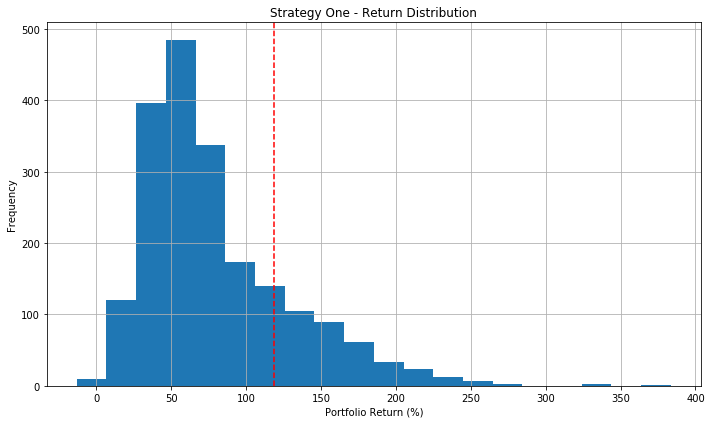

In [356]:
import statistics

print ("Strategy One Return - mean:{:.1f}%, std:{:.1f}%".format(statistics.mean(returns),statistics.stdev(returns)))
plt.figure(figsize=(10, 6))
num_bins = 20
plt.hist(returns,num_bins)
plt.xlabel('Portfolio Return (%)')
plt.ylabel("Frequency")
plt.title("Strategy One - Return Distribution")

plt.axvline(x=118.613, color="red", linestyle='--')
plt.grid(True)
plt.tight_layout()

plt.show()